# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Building-a-Convolutional-Neural-Network" data-toc-modified-id="Building-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a Convolutional Neural Network</a></div><div class="lev2 toc-item"><a href="#Model-Definition" data-toc-modified-id="Model-Definition-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Definition</a></div><div class="lev2 toc-item"><a href="#Data-Generator" data-toc-modified-id="Data-Generator-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Generator</a></div><div class="lev2 toc-item"><a href="#Training" data-toc-modified-id="Training-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data Augmentation</a></div><div class="lev1 toc-item"><a href="#Visualizing-Feature-Maps" data-toc-modified-id="Visualizing-Feature-Maps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing Feature Maps</a></div><div class="lev1 toc-item"><a href="#Dense-Layer-Visualization" data-toc-modified-id="Dense-Layer-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dense Layer Visualization</a></div><div class="lev1 toc-item"><a href="#Visualizing-Convnet-Filters" data-toc-modified-id="Visualizing-Convnet-Filters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Convnet Filters</a></div>

In [ ]:
!pip install tf-keras-vis
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Nuevas importaciones desde tf-keras-vis
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.9 MB/s eta 0:00:00


# Utility Functions

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['acc'])
    acc = smooth_curve(history.history['acc'][:steps])
    val_acc = smooth_curve(history.history['val_acc'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from google.colab import files
files.upload()  # Selecciona el archivo `kaggle.json`


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josueflorianparraga","key":"bc8fc14d2397cca2dfc3c65120dff527"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hongweicao/catanddogsmall
!unzip catanddogsmall.zip -d ./cats_and_dogs_small

Dataset URL: https://www.kaggle.com/datasets/hongweicao/catanddogsmall
License(s): unknown
100% 122M/122M [00:28<00:00, 4.74MB/s]
100% 122M/122M [00:28<00:00, 4.49MB/s]
Archive:  catanddogsmall.zip
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1500.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1501.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1502.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1503.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1504.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1505.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1506.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1507.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1508.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1509.jpg  
  inflating: ./cats_and_dogs_small/dogvscat_small/test/cats/1510.jpg  
  inflating: ./cats_a

## Data Generator

In [ ]:
base_dir = '/content/cats_and_dogs_small/dogvscat_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/cats_and_dogs_small/dogvscat_small/test',  # Ruta a tus datos de validación
    target_size=(150, 150),     # Tamaño de las imágenes de entrada
    batch_size=32,
    class_mode='binary')        # Tipo de salida (binary, categorical, etc.)


Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,  # Asegúrate de que haya suficientes datos para estos pasos
    verbose=1)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.4990 - loss: 0.7055 - val_accuracy: 0.5600 - val_loss: 0.6891
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5600 - val_loss: 0.6891
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5407 - loss: 0.6796 - val_accuracy: 0.5010 - val_loss: 0.6934
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5010 - val_loss: 0.6934
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5060 - loss: 0.6930 - val_accuracy: 0.5010 - val_loss: 0.6928
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5010 - val_loss: 0.6928
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5131 - loss: 0.6932 - val_accuracy: 0.5010 - val_loss: 0.6929
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e

In [ ]:
model.save('model.keras')
save_history(history, 'history.bin')

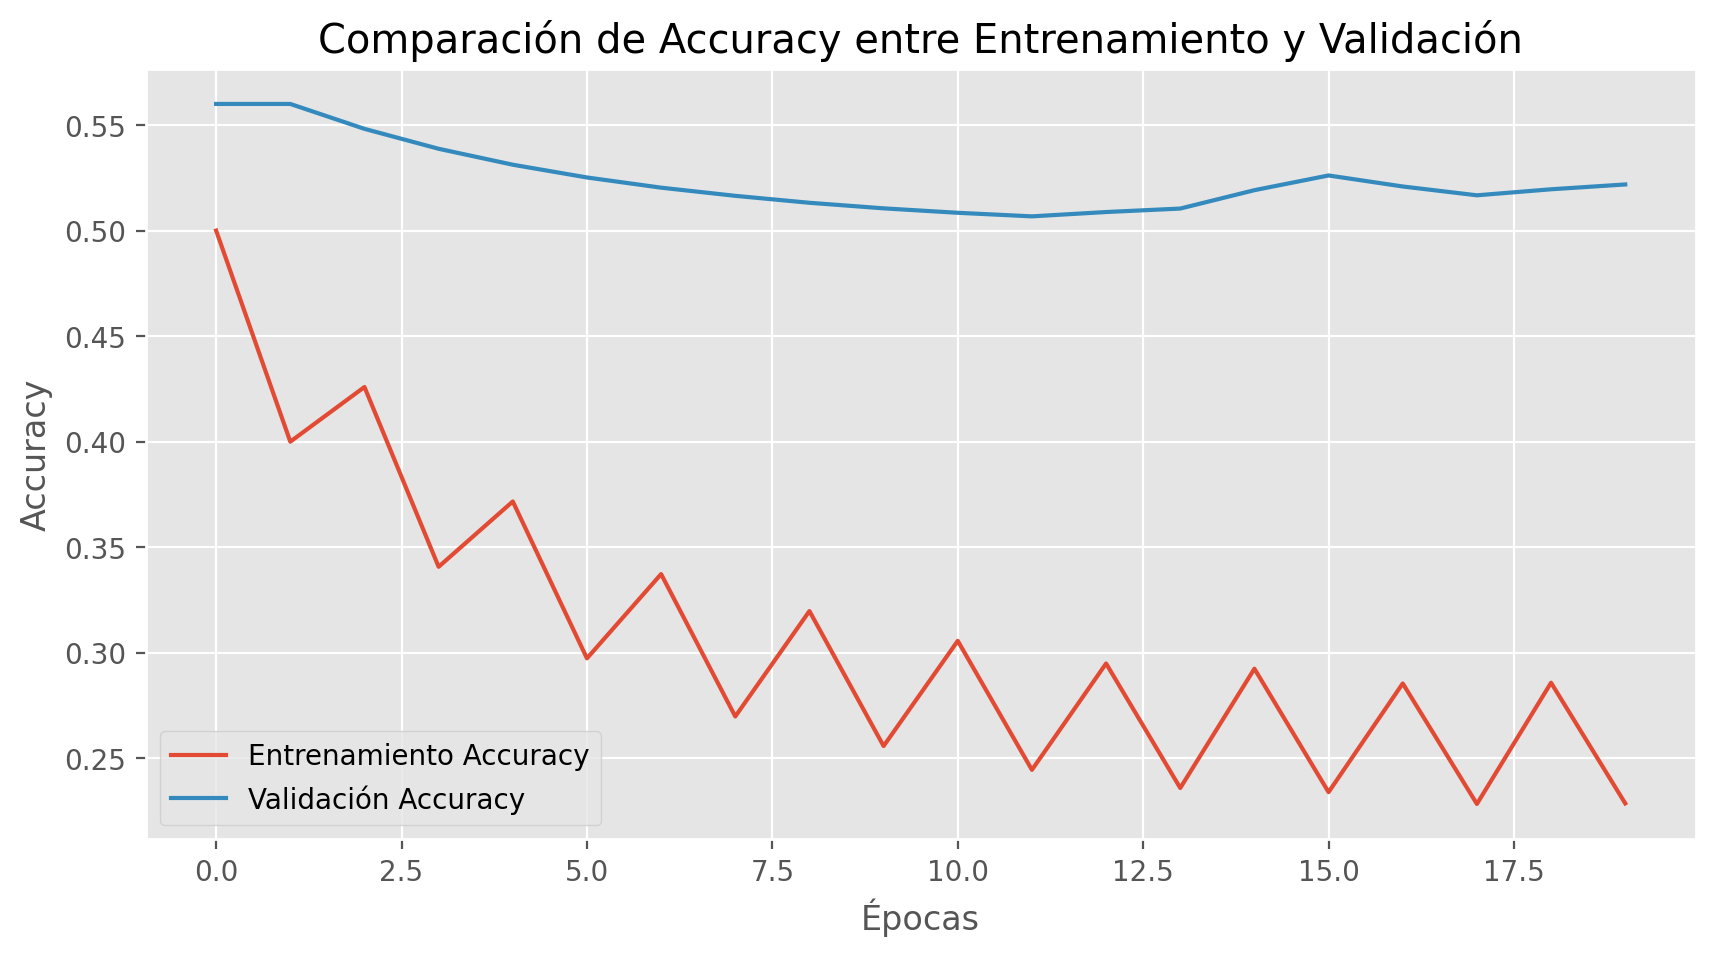

In [ ]:
def plot_compare(history, steps=-1):
    # Revisar si las claves actuales son 'accuracy' y 'val_accuracy'
    if 'accuracy' in history.history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    elif 'acc' in history.history:
        acc_key = 'acc'
        val_acc_key = 'val_acc'
    else:
        raise KeyError("Las claves 'accuracy' o 'acc' no existen en el historial. Revisa las métricas que fueron monitorizadas durante el entrenamiento.")

    if steps < 0:
        steps = len(history.history[acc_key])

    # Suavizar los datos si es necesario (asumiendo que tienes una función smooth_curve)
    acc = smooth_curve(history.history[acc_key][:steps])
    val_acc = smooth_curve(history.history[val_acc_key][:steps])

    # Crear el gráfico de comparación
    plt.figure(figsize=(10, 5))
    plt.plot(acc, label='Entrenamiento Accuracy')
    plt.plot(val_acc, label='Validación Accuracy')
    plt.title('Comparación de Accuracy entre Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Cargar el historial y mostrar el gráfico
history = load_history('history.bin')
plot_compare(history)


## Data Augmentation

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=0)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

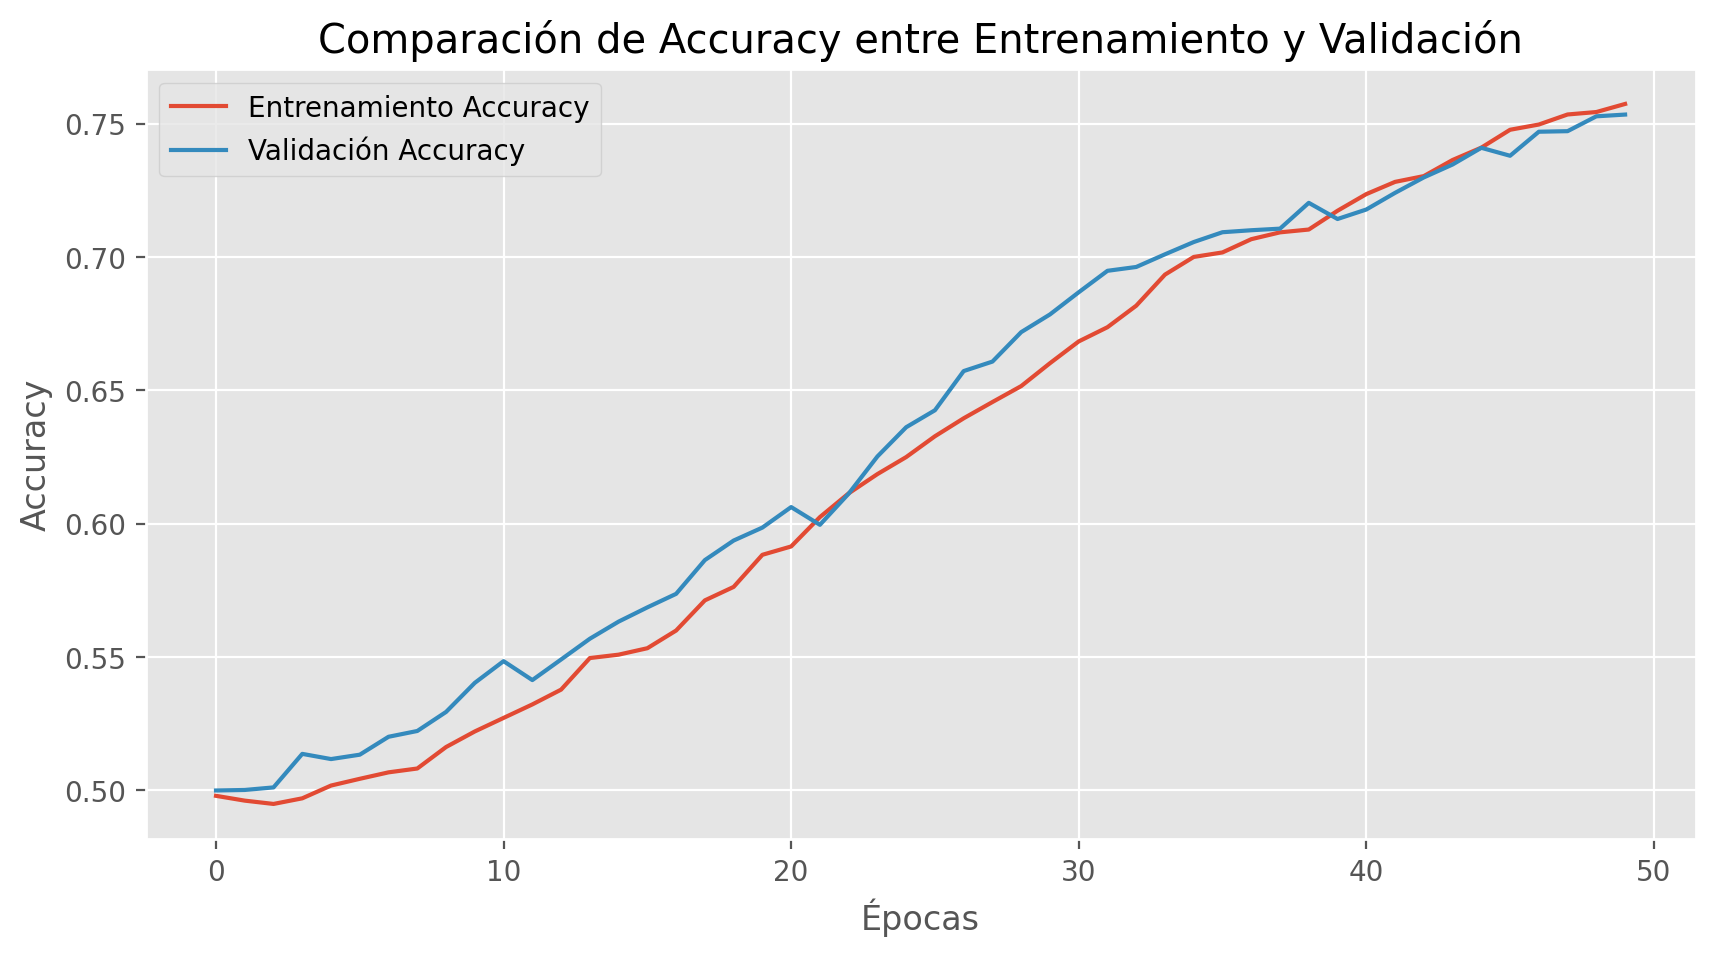

In [ ]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

# Visualizing Feature Maps

In [ ]:
img_path = '/content/cats_and_dogs_small/dogvscat_small/train/cats/107.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


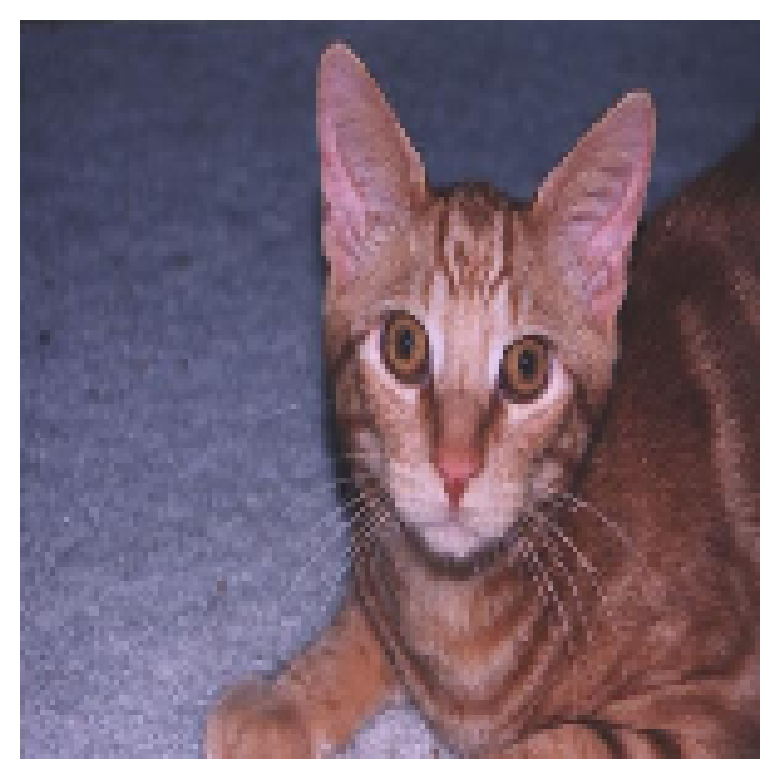

In [ ]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


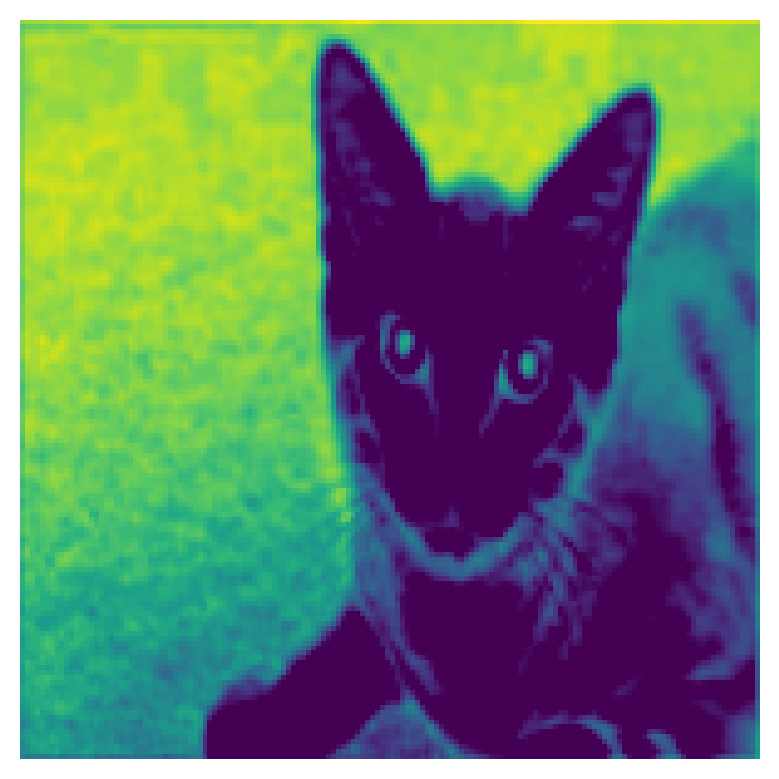

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


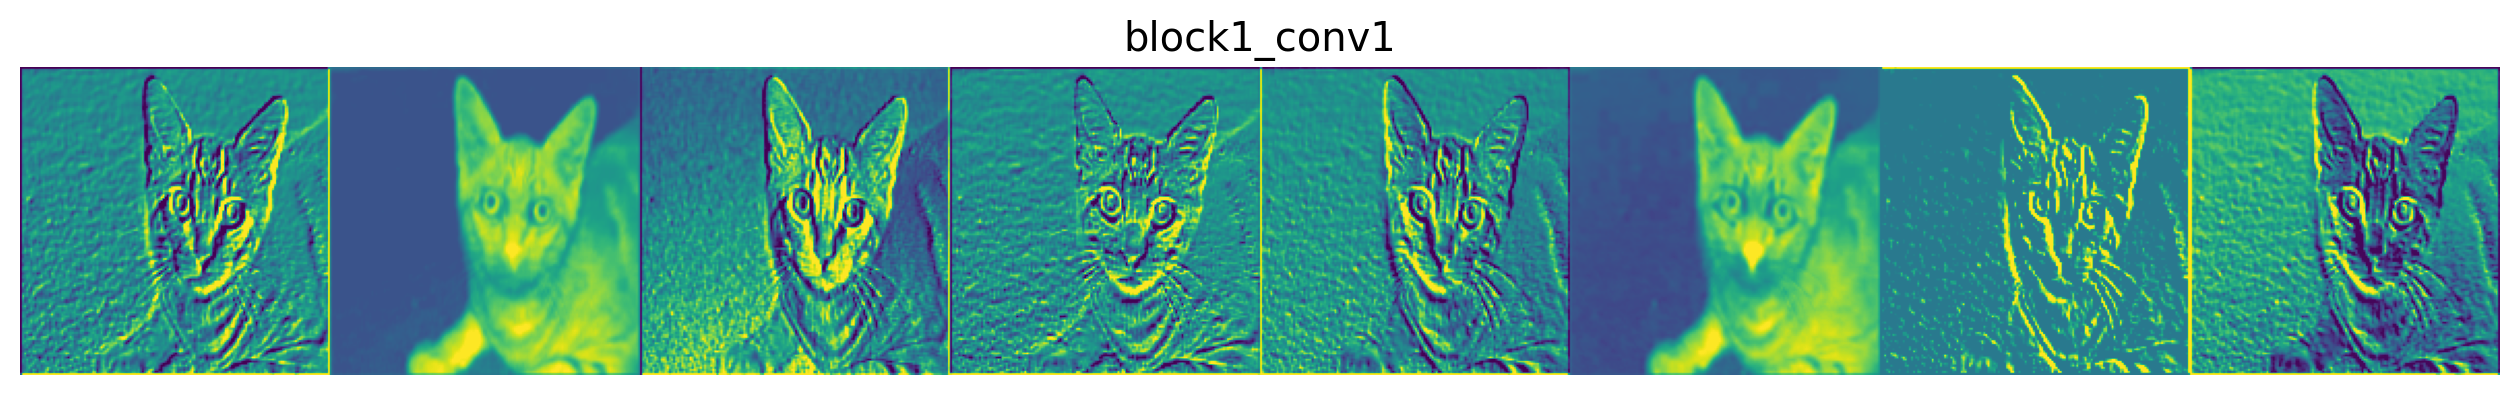

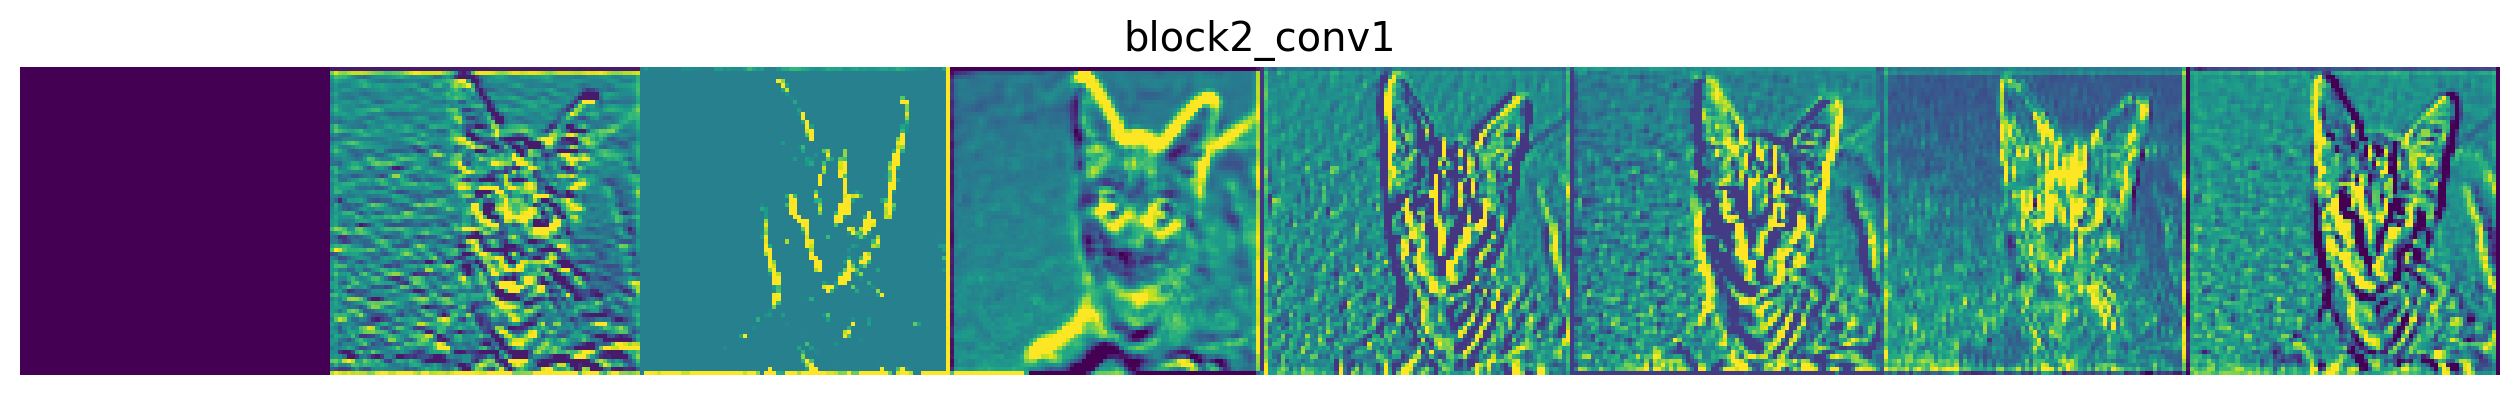

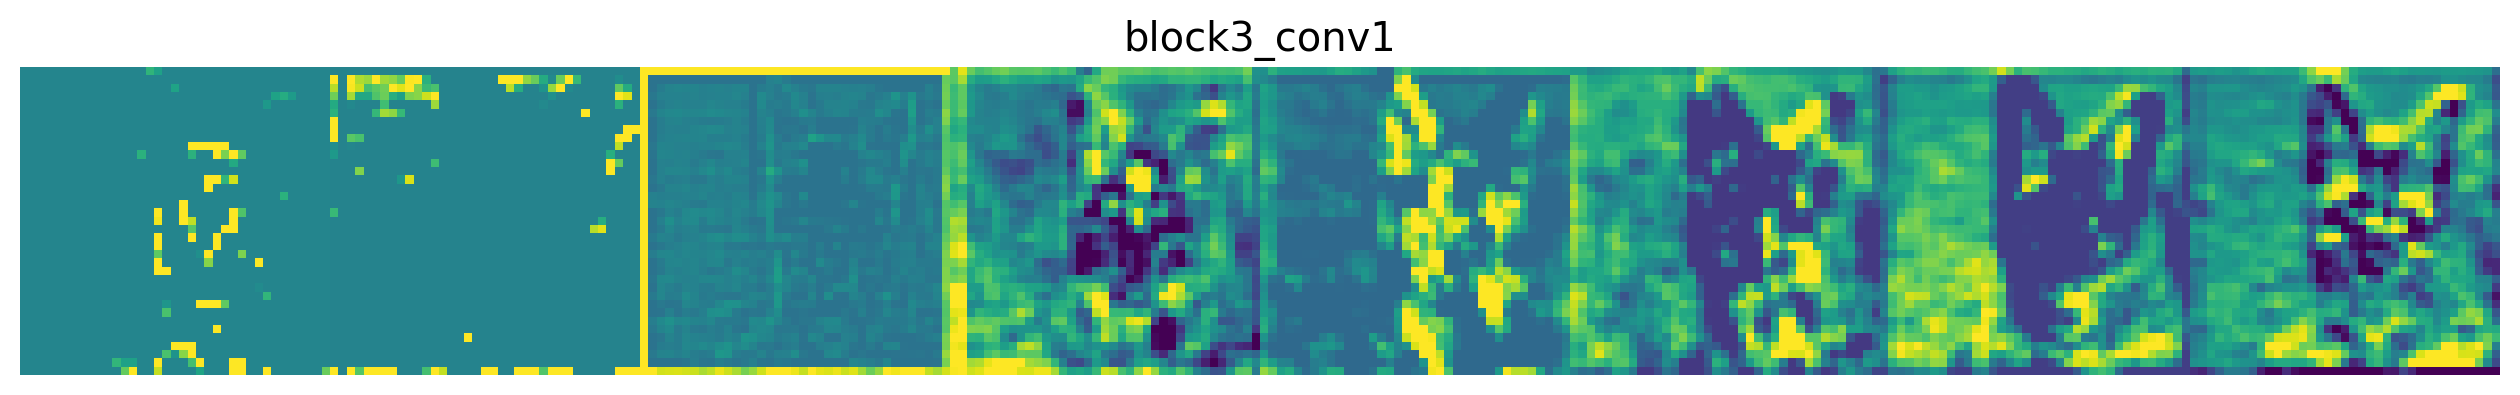

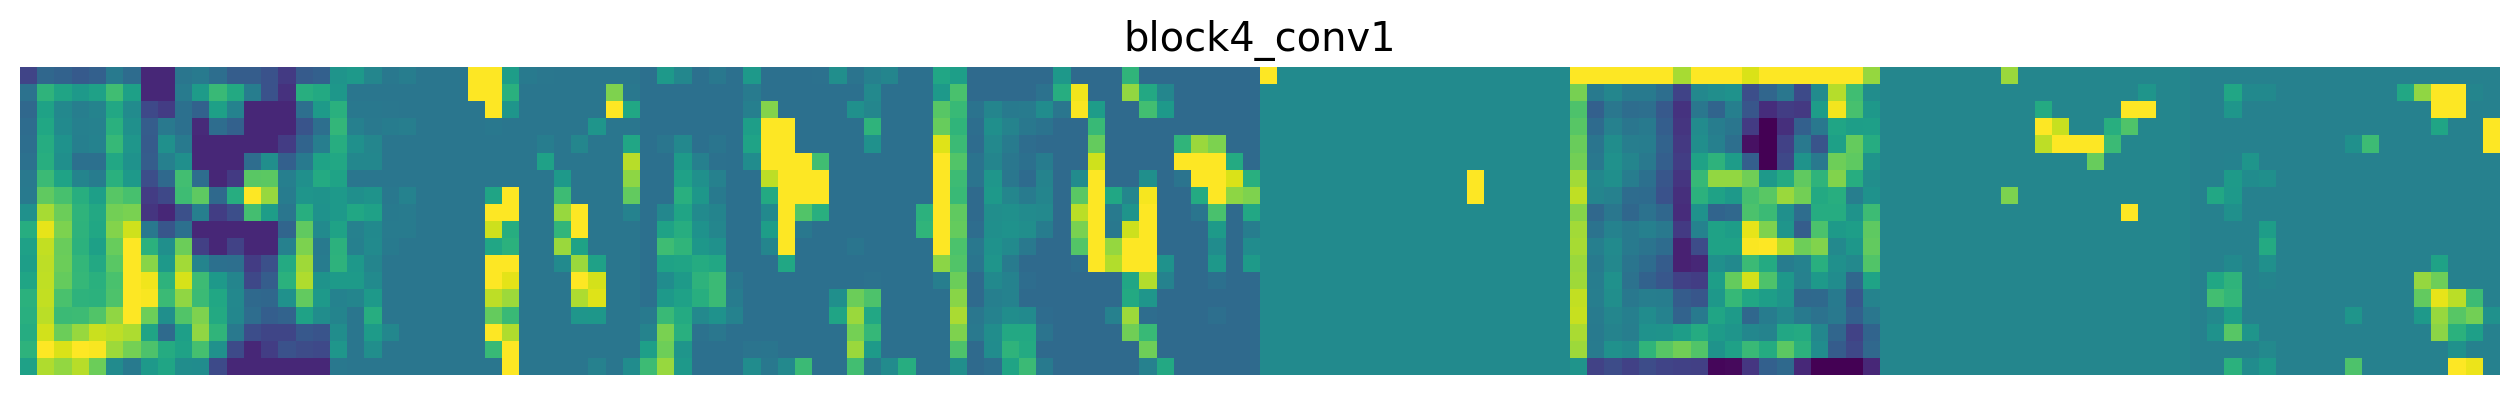

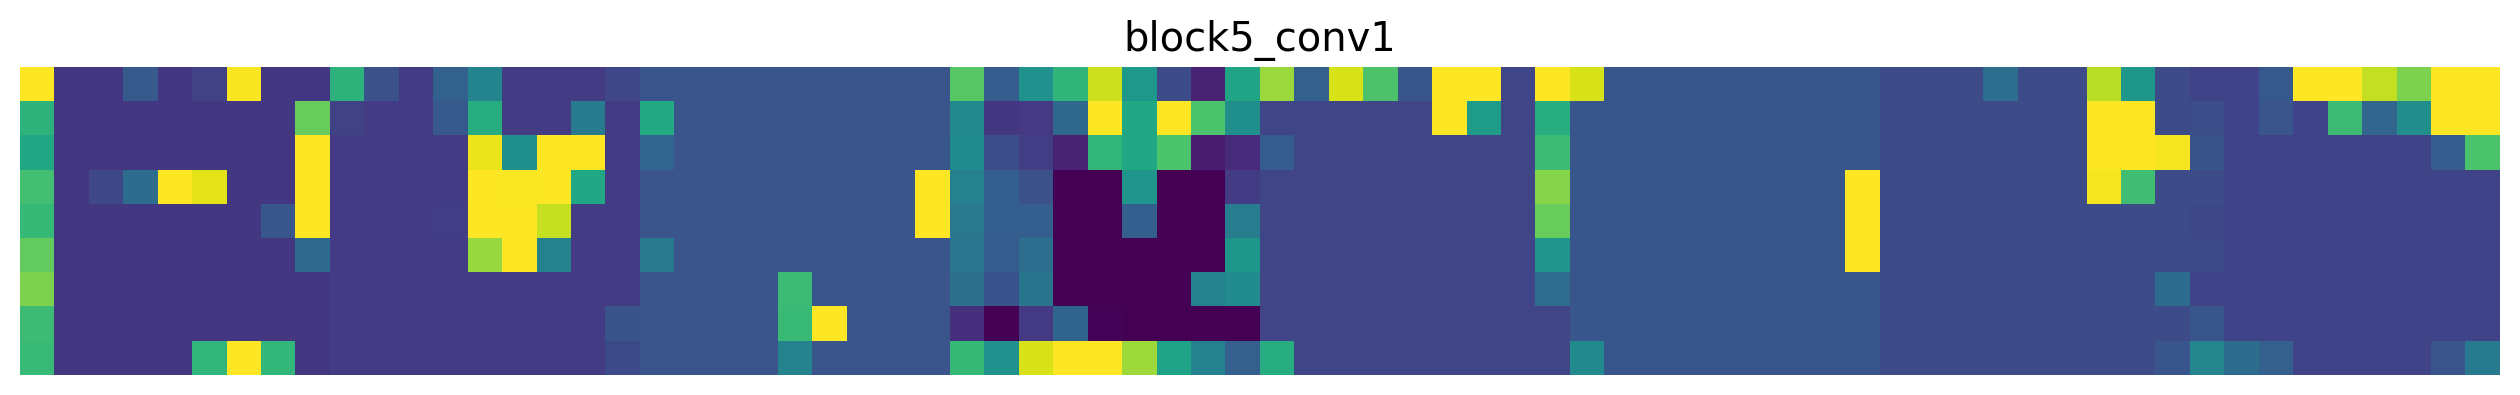

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


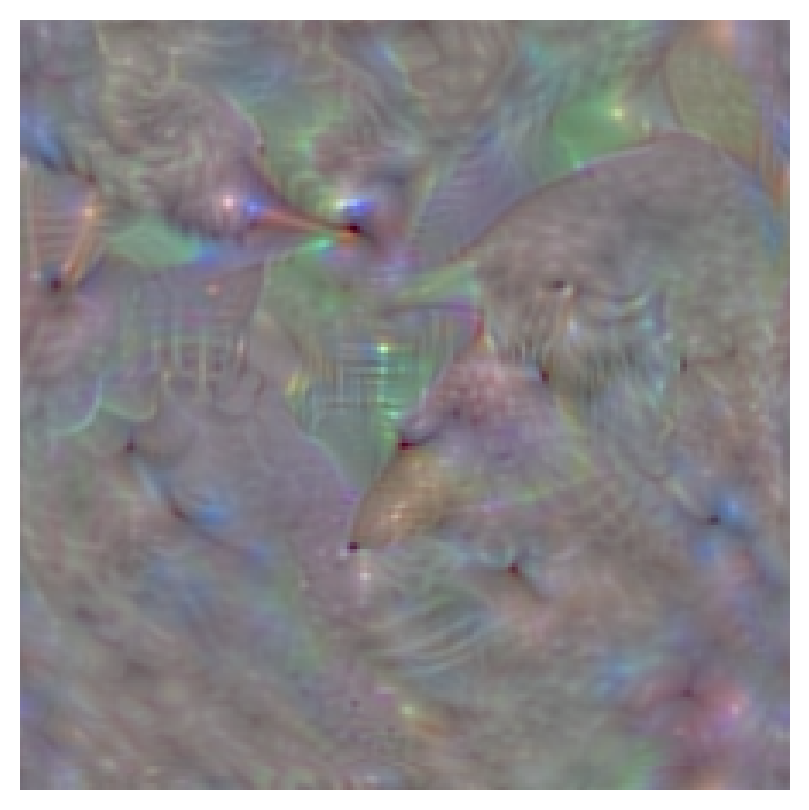

In [ ]:
from tensorflow.keras.applications import VGG16
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
import matplotlib.pyplot as plt

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Create a model modifier to replace the softmax activation with linear
modifier = ReplaceToLinear()

# Create the Activation Maximization instance
activation_maximization = ActivationMaximization(model, model_modifier=modifier)

# Perform activation maximization
# 20 is the class index for 'ouzel'
img = activation_maximization(CategoricalScore(20))

# Remove the extra dimension and ensure the image is in the right format
img = np.squeeze(img)  # Remove single-dimensional entries from the shape
img = np.clip(img, 0, 255).astype('uint8')  # Ensure values are in the range [0, 255]

# Plot the image
def plot_image(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_image(img)

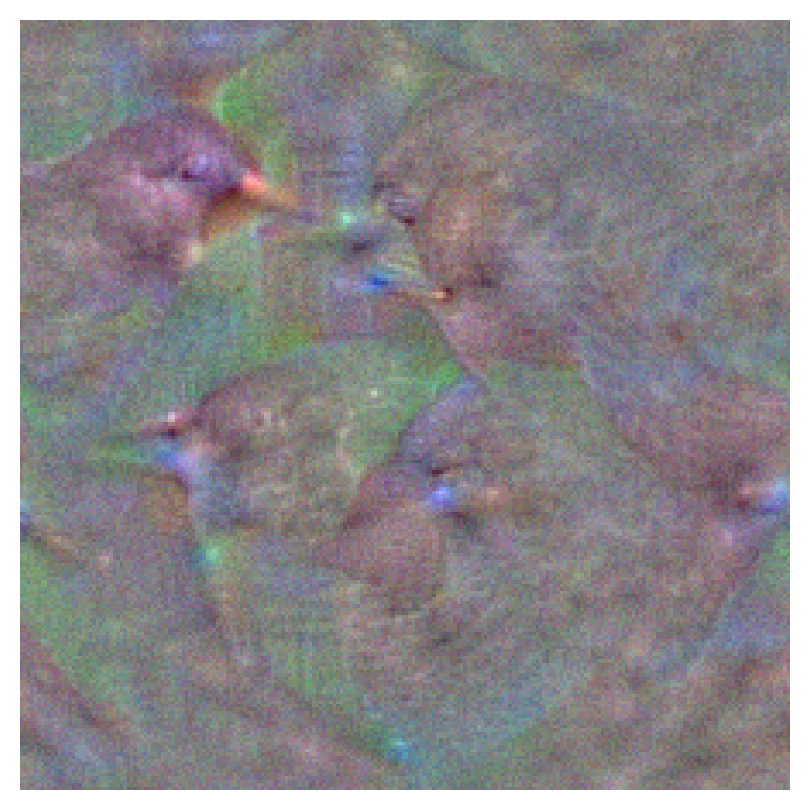

In [ ]:
from tensorflow.keras.applications import VGG16
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import numpy as np
import matplotlib.pyplot as plt

# Define the Jitter class
class Jitter:
    def __init__(self, amount):
        self.amount = amount

    def __call__(self, image):
        jitter = np.random.uniform(-self.amount, self.amount, size=image.shape)
        return np.clip(image + jitter, 0, 255)

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Create a model modifier to replace the softmax activation with linear
modifier = ReplaceToLinear()

# Create the Activation Maximization instance
activation_maximization = ActivationMaximization(model, model_modifier=modifier)

# Perform activation maximization
# Note: Jitter and max_iter might need to be handled differently
score = CategoricalScore(20)
img = activation_maximization(score)

# Apply Jitter manually if needed
jitter_amount = 16
img = Jitter(jitter_amount)(img)

# Remove the extra dimension and ensure the image is in the right format
img = np.squeeze(img)  # Remove single-dimensional entries from the shape
img = np.clip(img, 0, 255).astype('uint8')  # Ensure values are in the range [0, 255]

# Plot the image
def plot_image(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

plot_image(img)


Layer 1 (block1_conv1): 64 filters
Layer 2 (block1_conv2): 64 filters
Layer 4 (block2_conv1): 128 filters
Layer 5 (block2_conv2): 128 filters
Layer 7 (block3_conv1): 256 filters
Layer 8 (block3_conv2): 256 filters
Layer 9 (block3_conv3): 256 filters
Layer 11 (block4_conv1): 512 filters
Layer 12 (block4_conv2): 512 filters
Layer 13 (block4_conv3): 512 filters
Layer 15 (block5_conv1): 512 filters
Layer 16 (block5_conv2): 512 filters
Layer 17 (block5_conv3): 512 filters
Skipping bridge with invalid filter index 839
Skipping tennis ball with invalid filter index 852
Skipping gondola with invalid filter index 576
Skipping dumbbell with invalid filter index 543
Skipping hammer with invalid filter index 587
Skipping lamp with invalid filter index 846


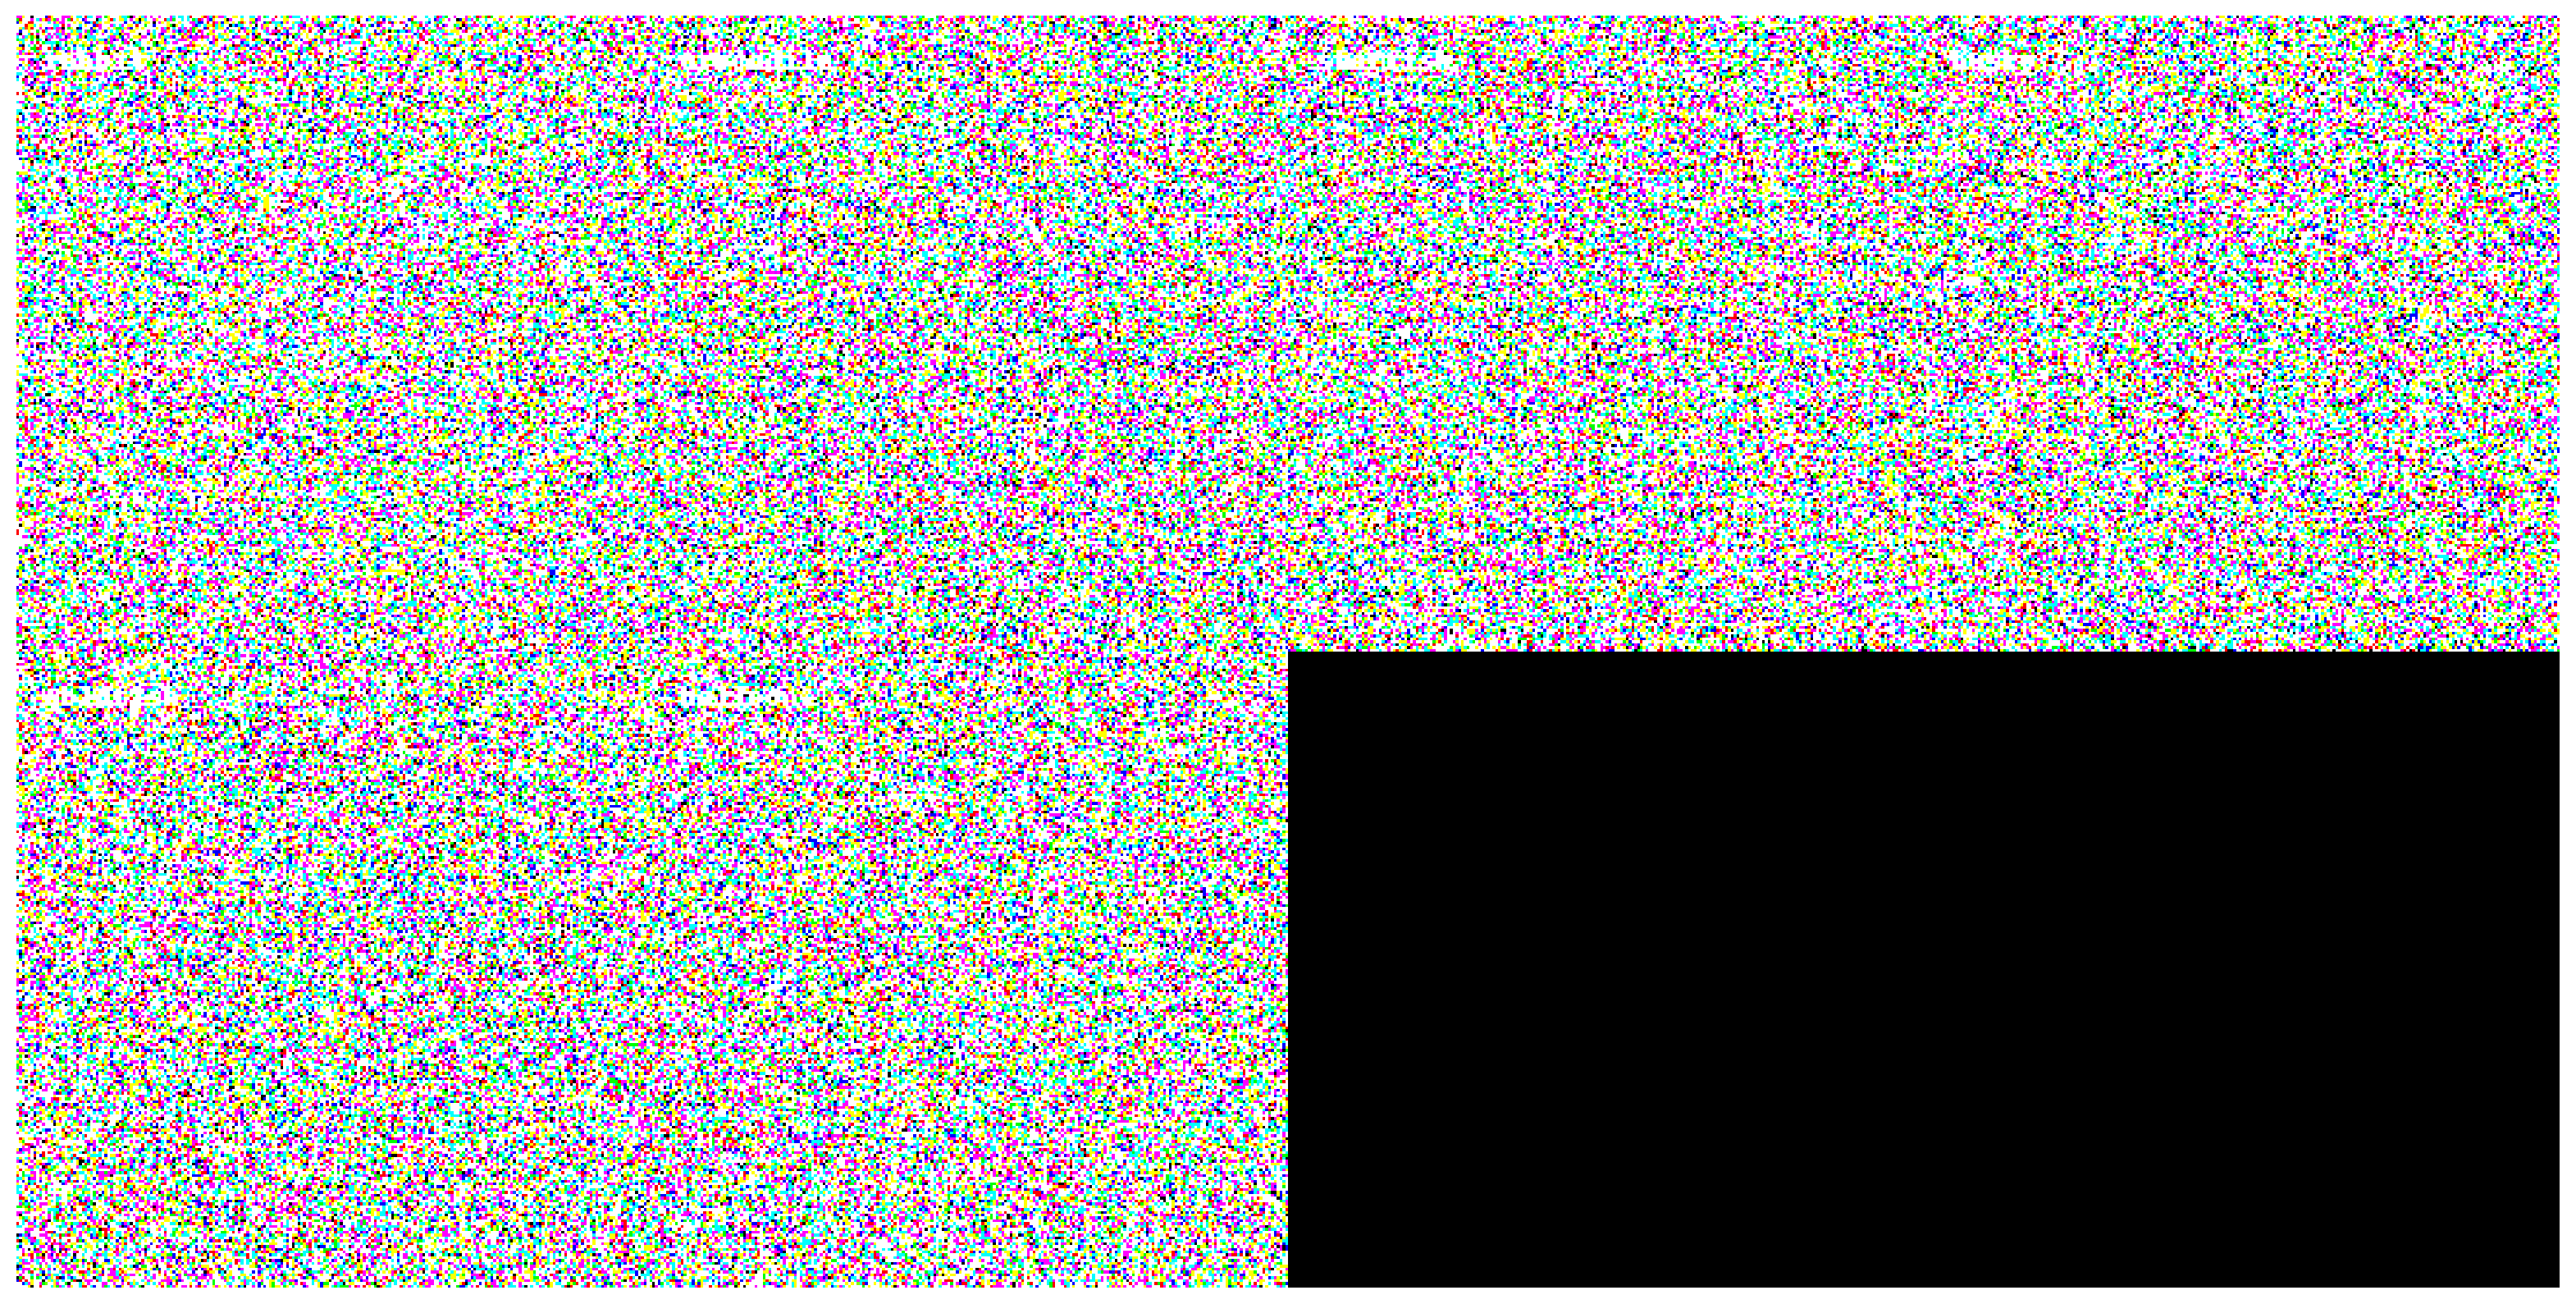

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import array_to_img

# Define the Jitter input modifier
def Jitter(jitter_strength):
    def jitter(image):
        return image + tf.random.uniform(tf.shape(image), -jitter_strength, jitter_strength)
    return jitter

# Define the visualize_activation function
def visualize_activation(model, layer_idx, filter_indices=None, seed_input=None, max_iter=300, tv_weight=1e-4, input_modifiers=None):
    # Ensure filter_indices is a list
    if not isinstance(filter_indices, list):
        filter_indices = [filter_indices]

    # Get the layer by index
    layer = model.layers[layer_idx]

    # Create a new model that outputs the activations of the specified layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer.output)

    # Initialize the input image
    if seed_input is None:
        # Generate random image as initial seed input
        seed_input = np.random.uniform(-0.5, 0.5, (224, 224, 3)).astype(np.float32)
    else:
        # Ensure seed_input is a float32 array with the correct shape
        seed_input = np.array(seed_input).astype(np.float32)
        # Remove the batch dimension if present
        if seed_input.ndim == 4 and seed_input.shape[0] == 1:
            seed_input = seed_input[0]

    input_img = tf.Variable(seed_input)

    # Define the loss function
    def loss_fn():
        activations = activation_model(input_img[tf.newaxis, ...])  # Add batch dimension
        if filter_indices:
            filter_activations = [tf.reduce_mean(activations[0, :, :, idx]) for idx in filter_indices]
            loss = -tf.reduce_sum(filter_activations)
        else:
            loss = -tf.reduce_mean(activations)

        # Total variation loss
        if tv_weight > 0:
            tv_loss = tf.image.total_variation(input_img)
            loss += tv_weight * tv_loss

        return loss

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Optimization loop
    for _ in range(max_iter):
        with tf.GradientTape() as tape:
            loss = loss_fn()
        grads = tape.gradient(loss, input_img)
        optimizer.apply_gradients([(grads, input_img)])

        # Apply input modifiers if any
        if input_modifiers:
            for modifier in input_modifiers:
                input_img.assign(modifier(input_img))

    # Post-process the result
    img_array = input_img.numpy()
    img_array = np.clip(img_array, 0, 1)  # Clip values to be between 0 and 1
    img_array = array_to_img(img_array)

    return img_array

# Define the draw_text function
def draw_text(img, text, position=(10, 10), font_size=20):
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(position, text, font=font, fill=(255, 255, 255))
    return img

# Define the stitch_images function
def stitch_images(images, cols=4):
    image_arrays = [np.array(img) for img in images]
    img_width, img_height = images[0].size
    rows = (len(images) + cols - 1) // cols
    stitched_image = np.zeros((rows * img_height, cols * img_width, 3), dtype=np.uint8)

    for idx, img_array in enumerate(image_arrays):
        row = idx // cols
        col = idx % cols
        stitched_image[row * img_height:(row + 1) * img_height, col * img_width:(col + 1) * img_width] = img_array

    return Image.fromarray(stitched_image)

# Load a pre-trained model
model = VGG16(weights='imagenet', include_top=False)

# Print the layers and their filter counts
for idx, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        output_shape = layer.output.shape
        print(f"Layer {idx} ({layer.name}): {output_shape[-1]} filters")

# Specify the layer index you want to visualize
layer_idx = 15  # Example index, adjust based on your output

# Your activation codes
codes = '''
rabbit 330
crocodile 49
starfish 327
husky 248
goldfish 1
bridge 839
balloon 417
tennis ball 852
gondola 576
dumbbell 543
hammer 587
lamp 846
'''

initial = []
images = []
tuples = []
for line in codes.split('\n'):
    if not line:
        continue
    name, idx = line.rsplit(' ', 1)
    idx = int(idx)
    # Check if the index is within the valid range for the layer
    num_filters = model.layers[layer_idx].output.shape[-1]
    if 0 <= idx < num_filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx,
                                   tv_weight=0., max_iter=300, input_modifiers=[Jitter(16)])
        initial.append(img)
        tuples.append((name, idx))
    else:
        print(f"Skipping {name} with invalid filter index {idx}")

i = 0
for name, idx in tuples:
    # Ensure the seed_input has the correct shape (224, 224, 3)
    seed_input = np.array(initial[i]).astype(np.float32)
    # Add batch dimension
    seed_input = np.expand_dims(seed_input, axis=0)  # Shape (1, 224, 224, 3)
    img = visualize_activation(model, layer_idx, filter_indices=idx,
                               seed_input=seed_input, max_iter=300, input_modifiers=[Jitter(16)])
    img = draw_text(img, name)
    i += 1
    images.append(img)

stitched = stitch_images(images, cols=4)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(stitched)
plt.show()


# Visualizing Convnet Filters

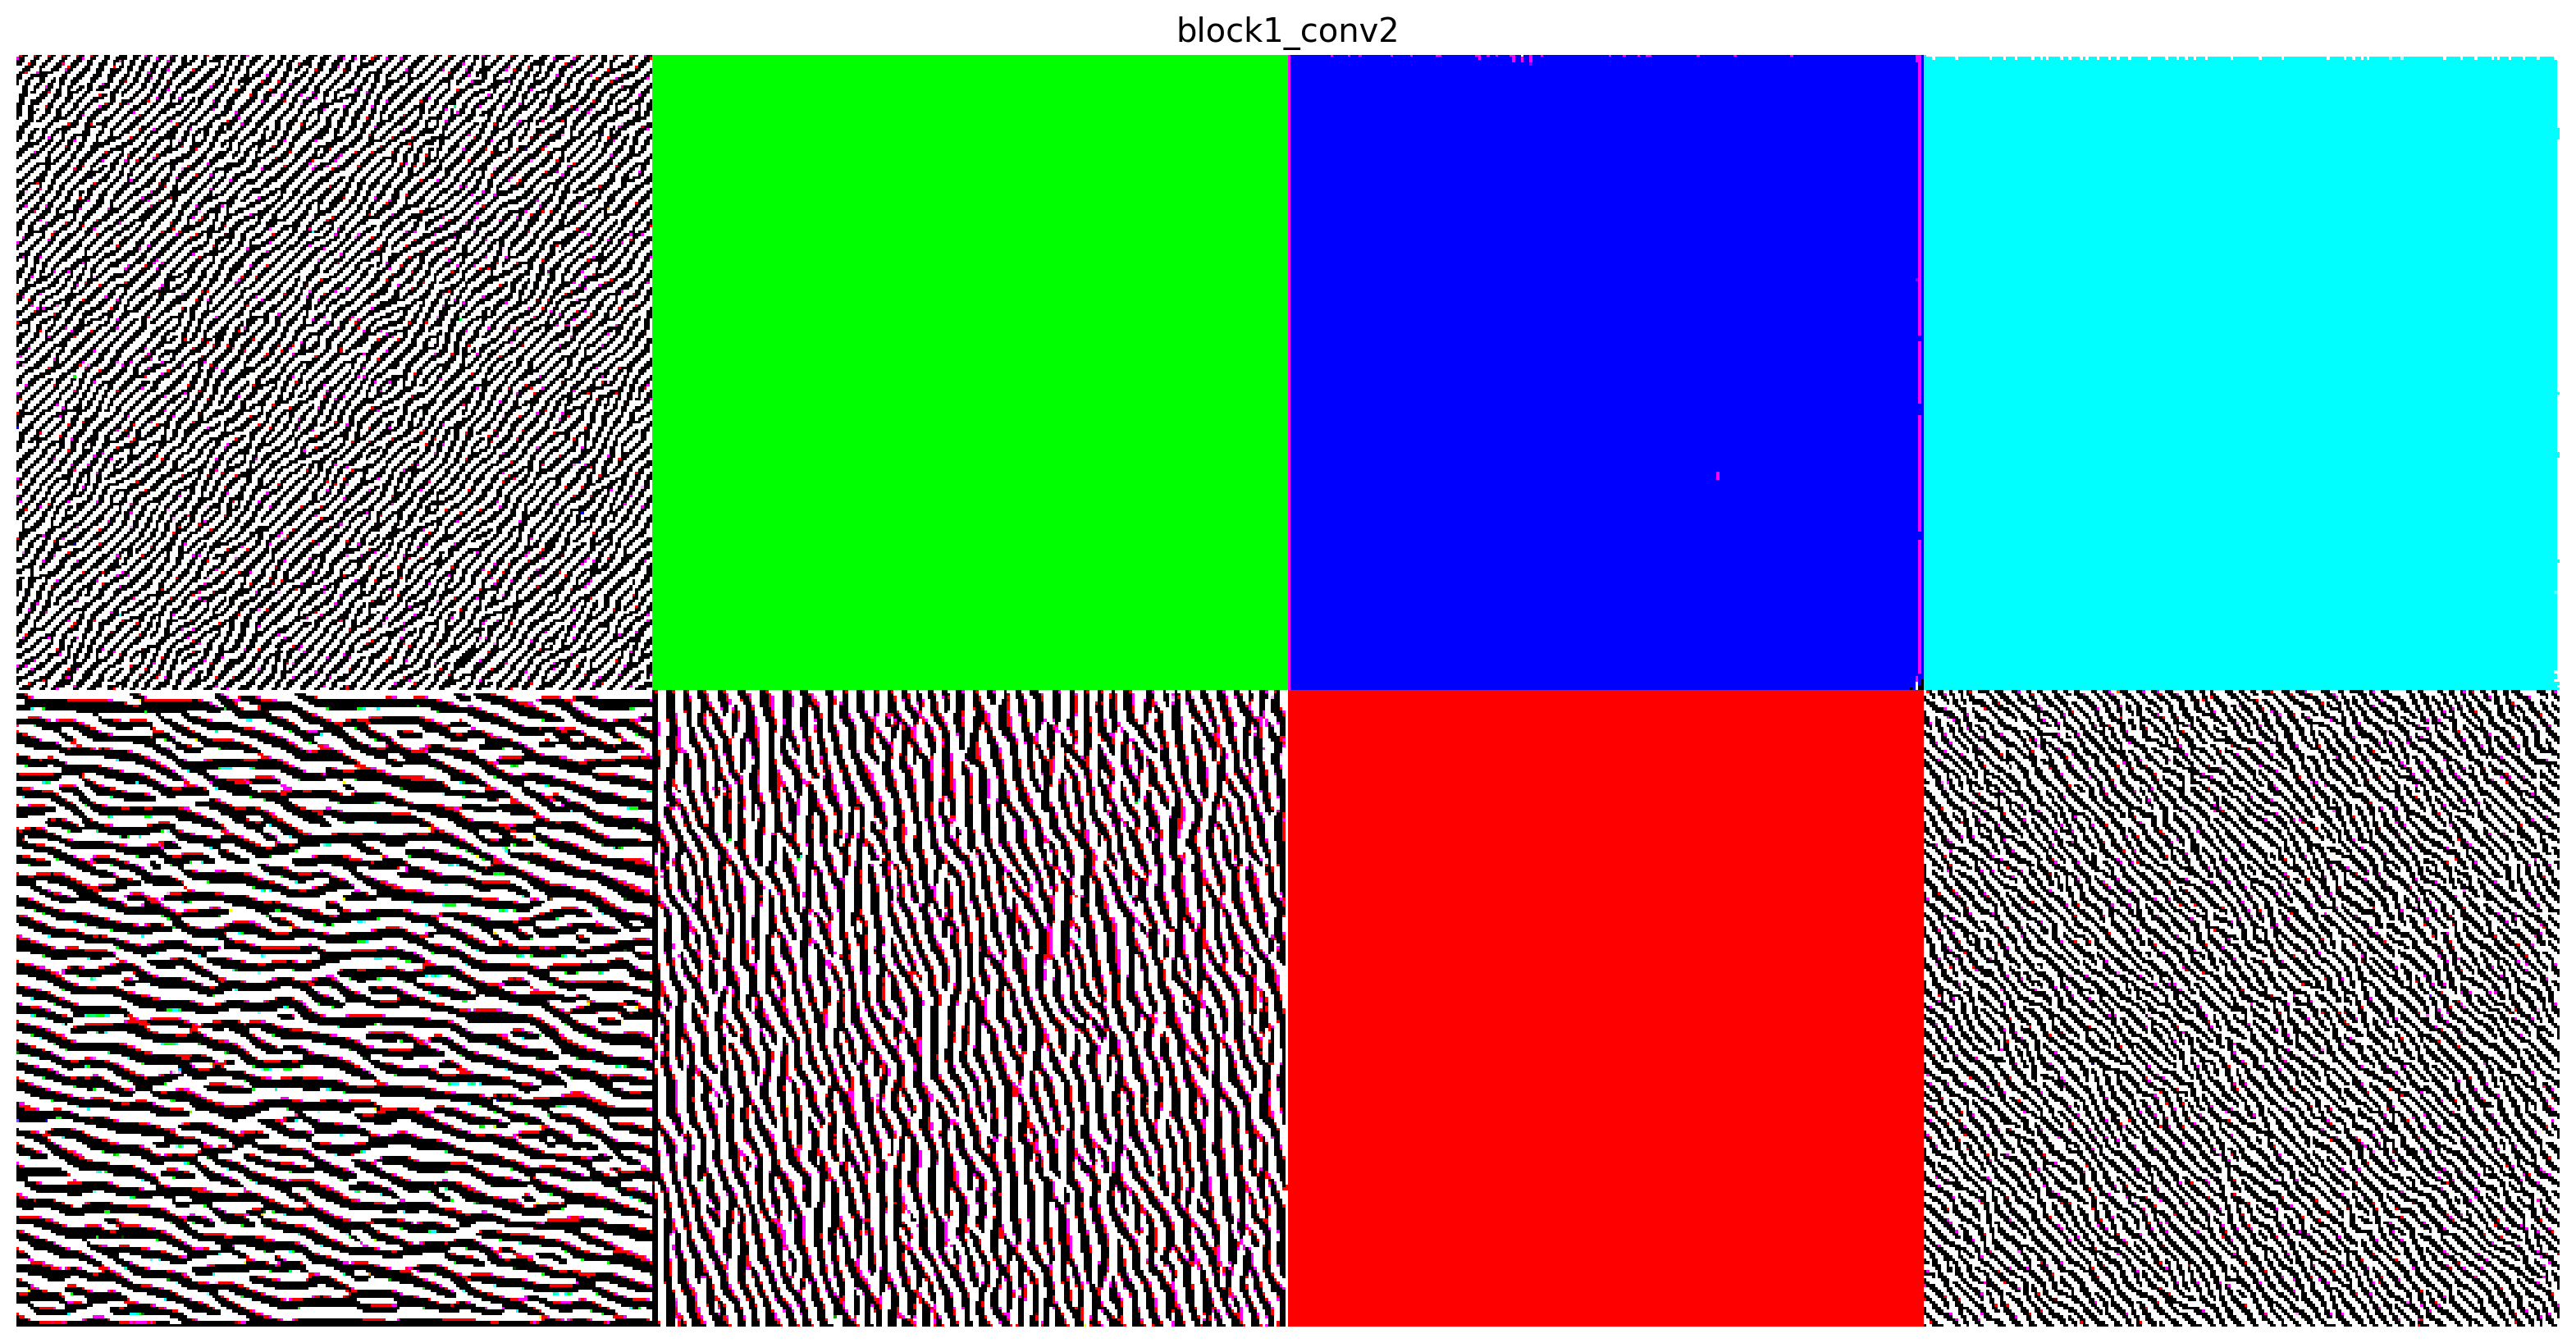

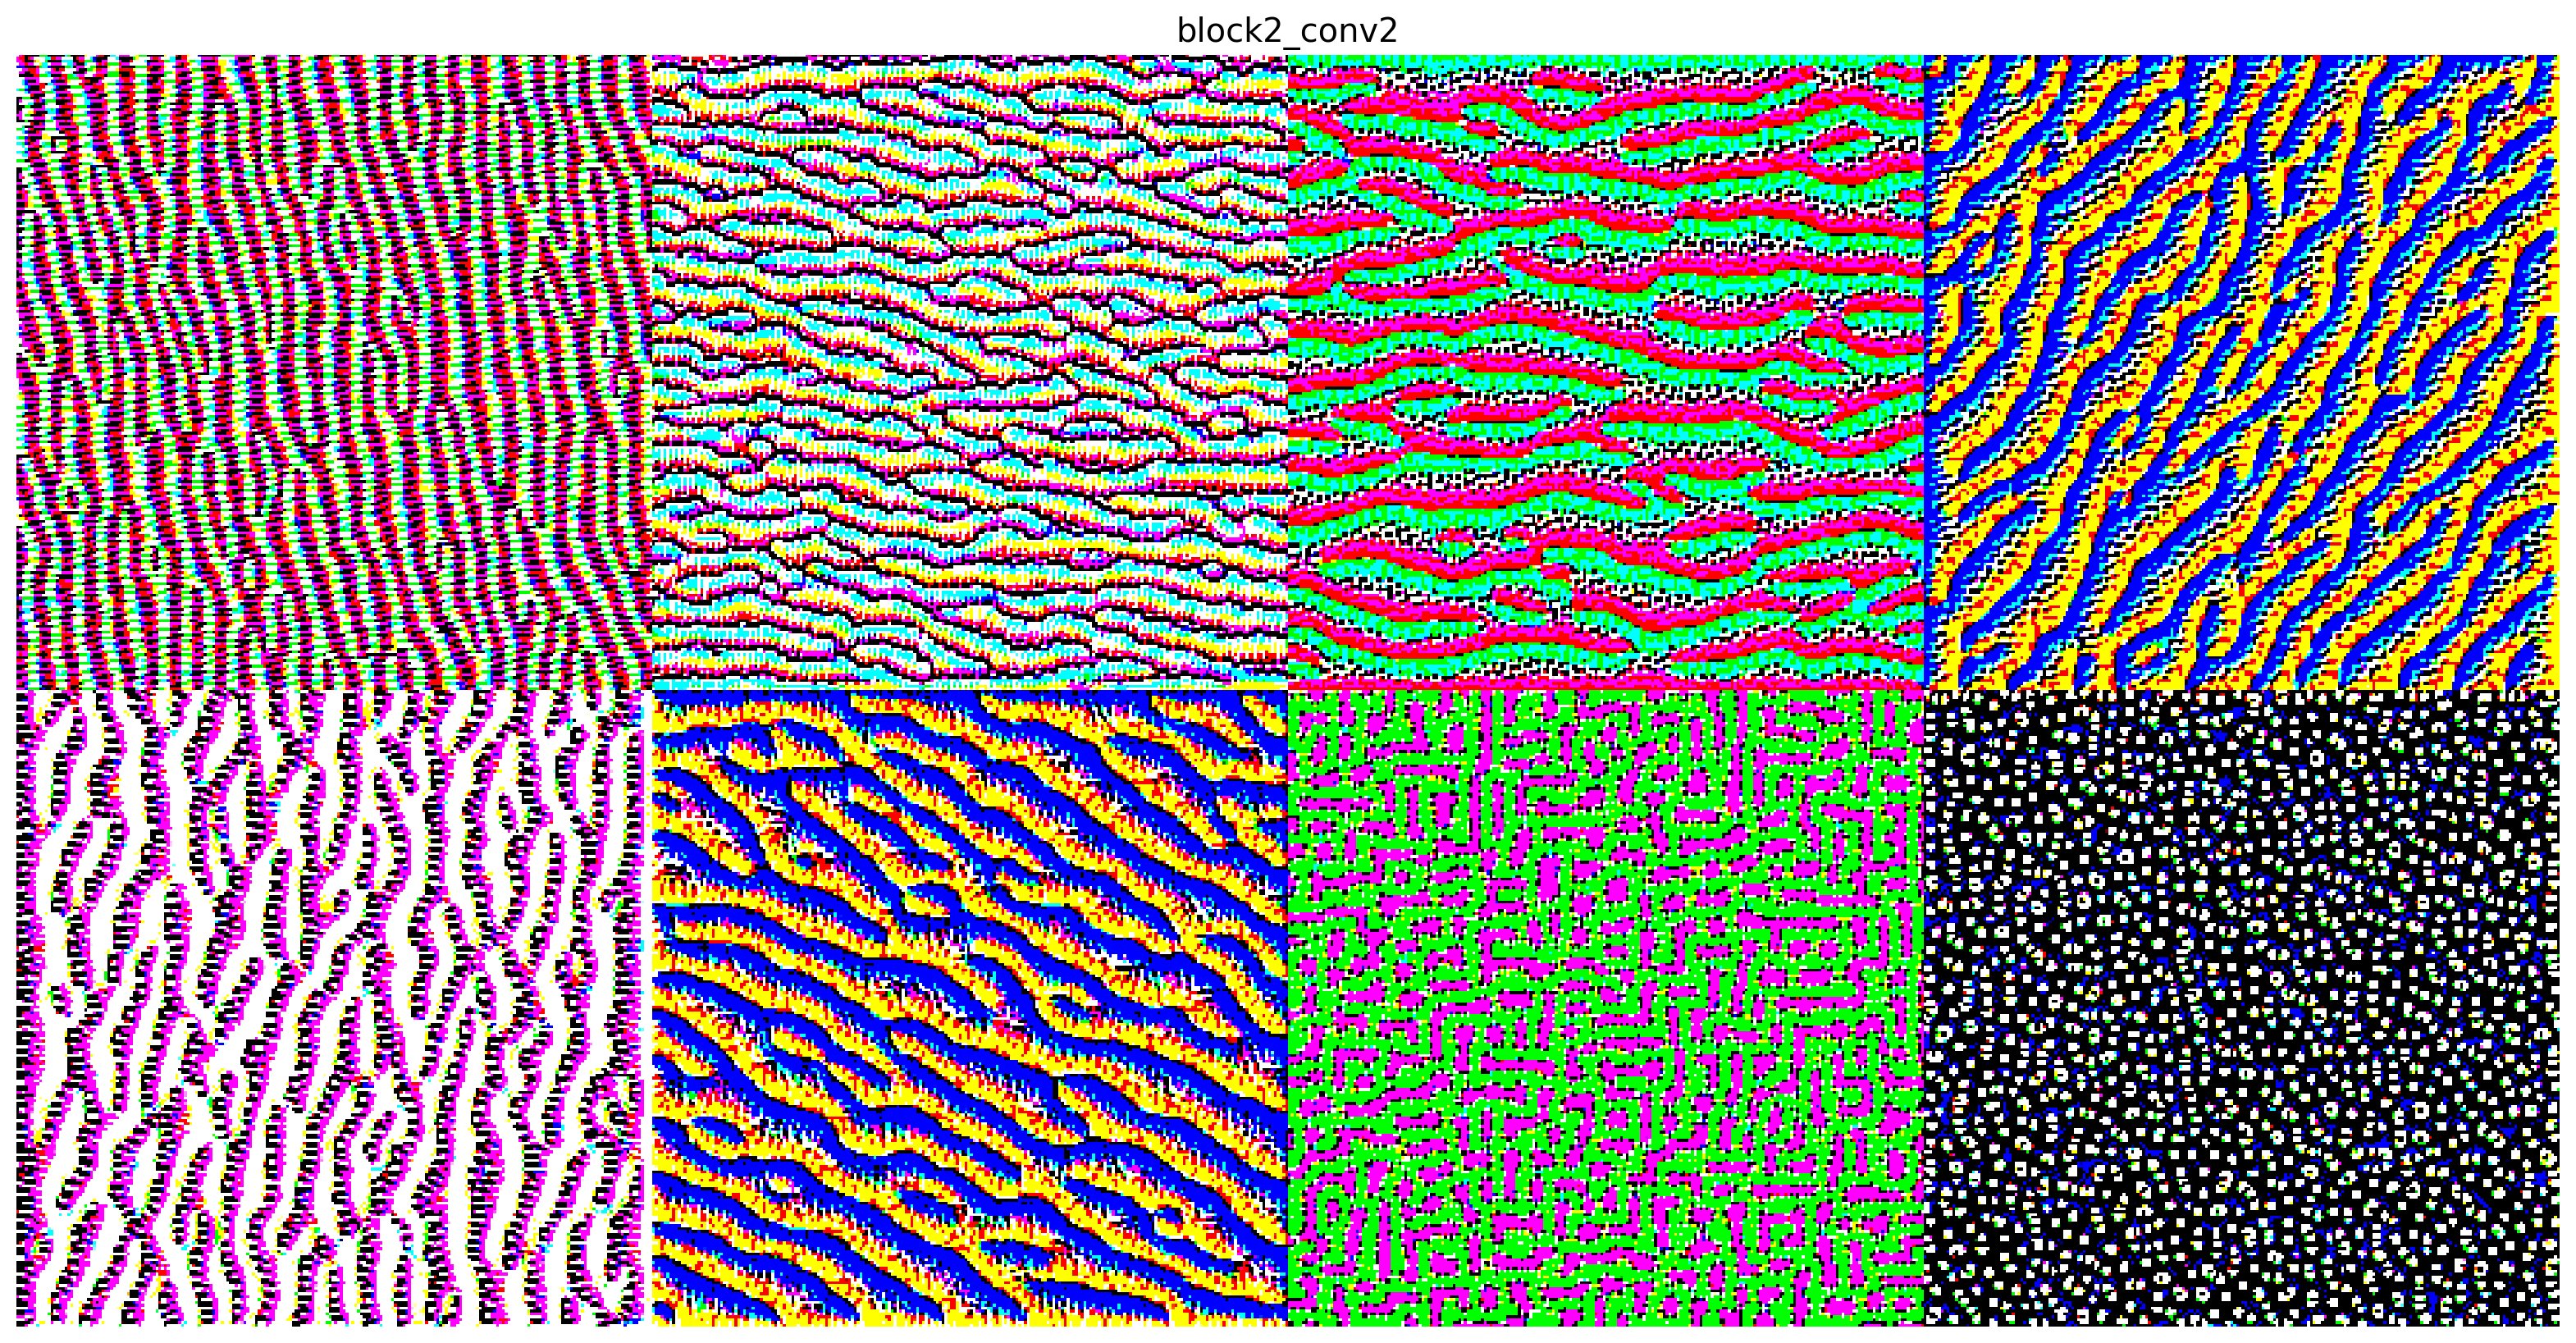

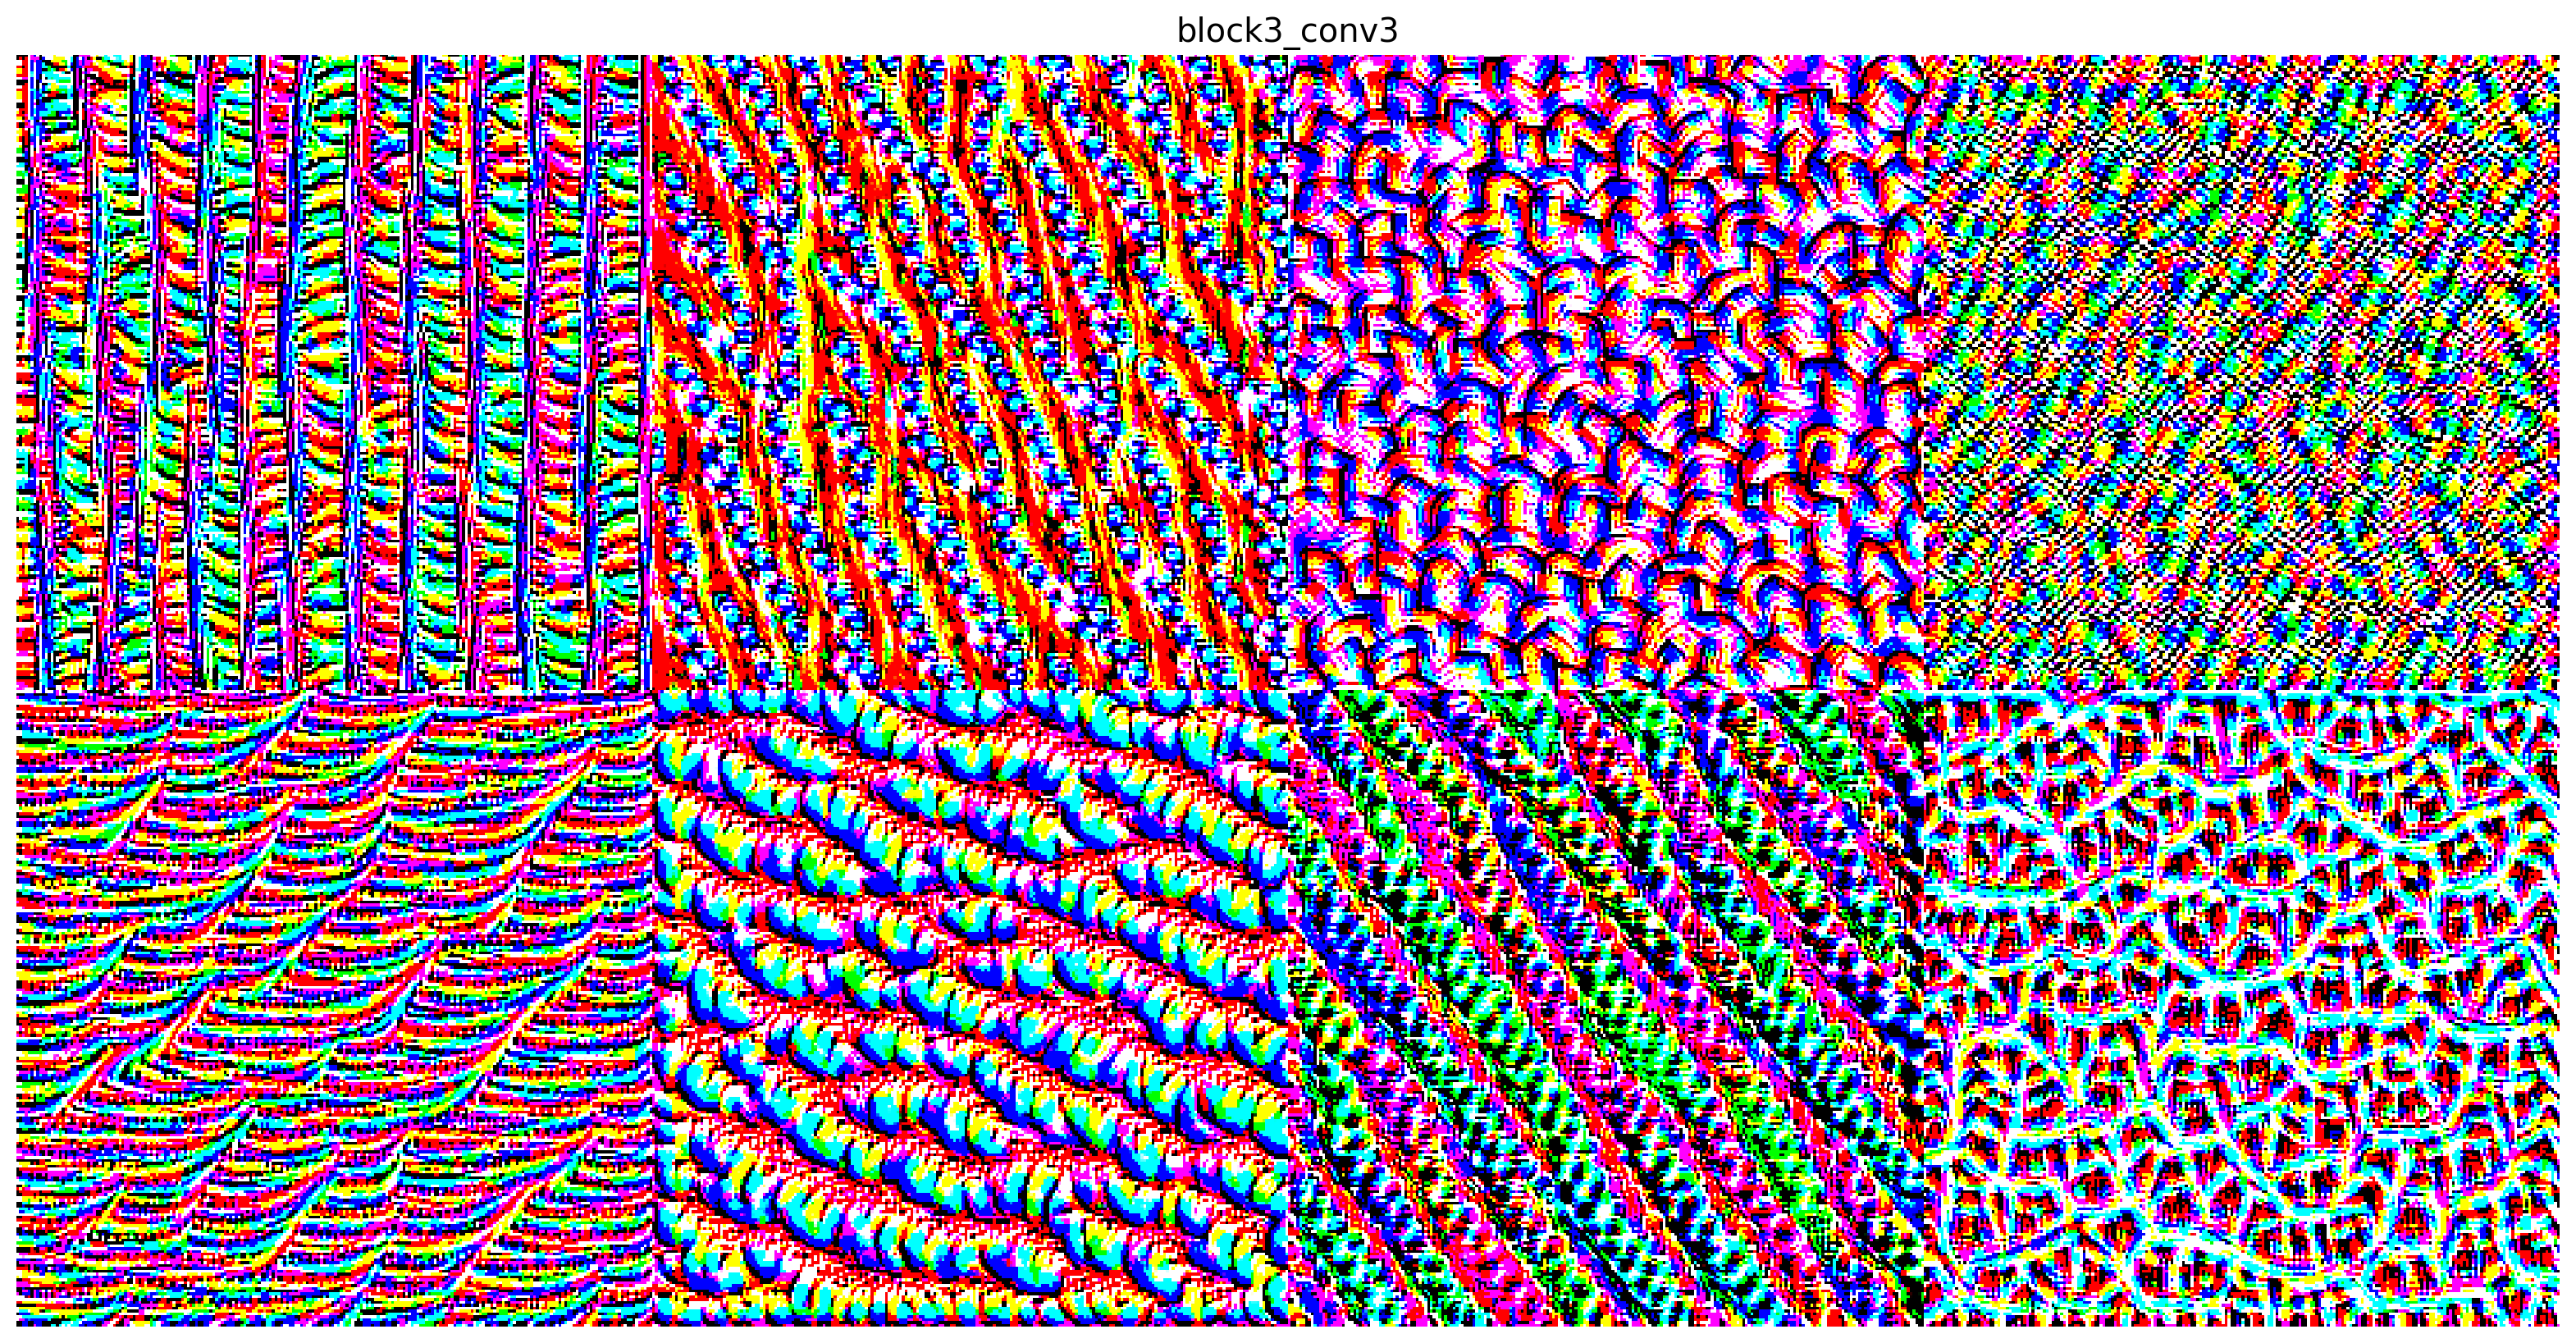

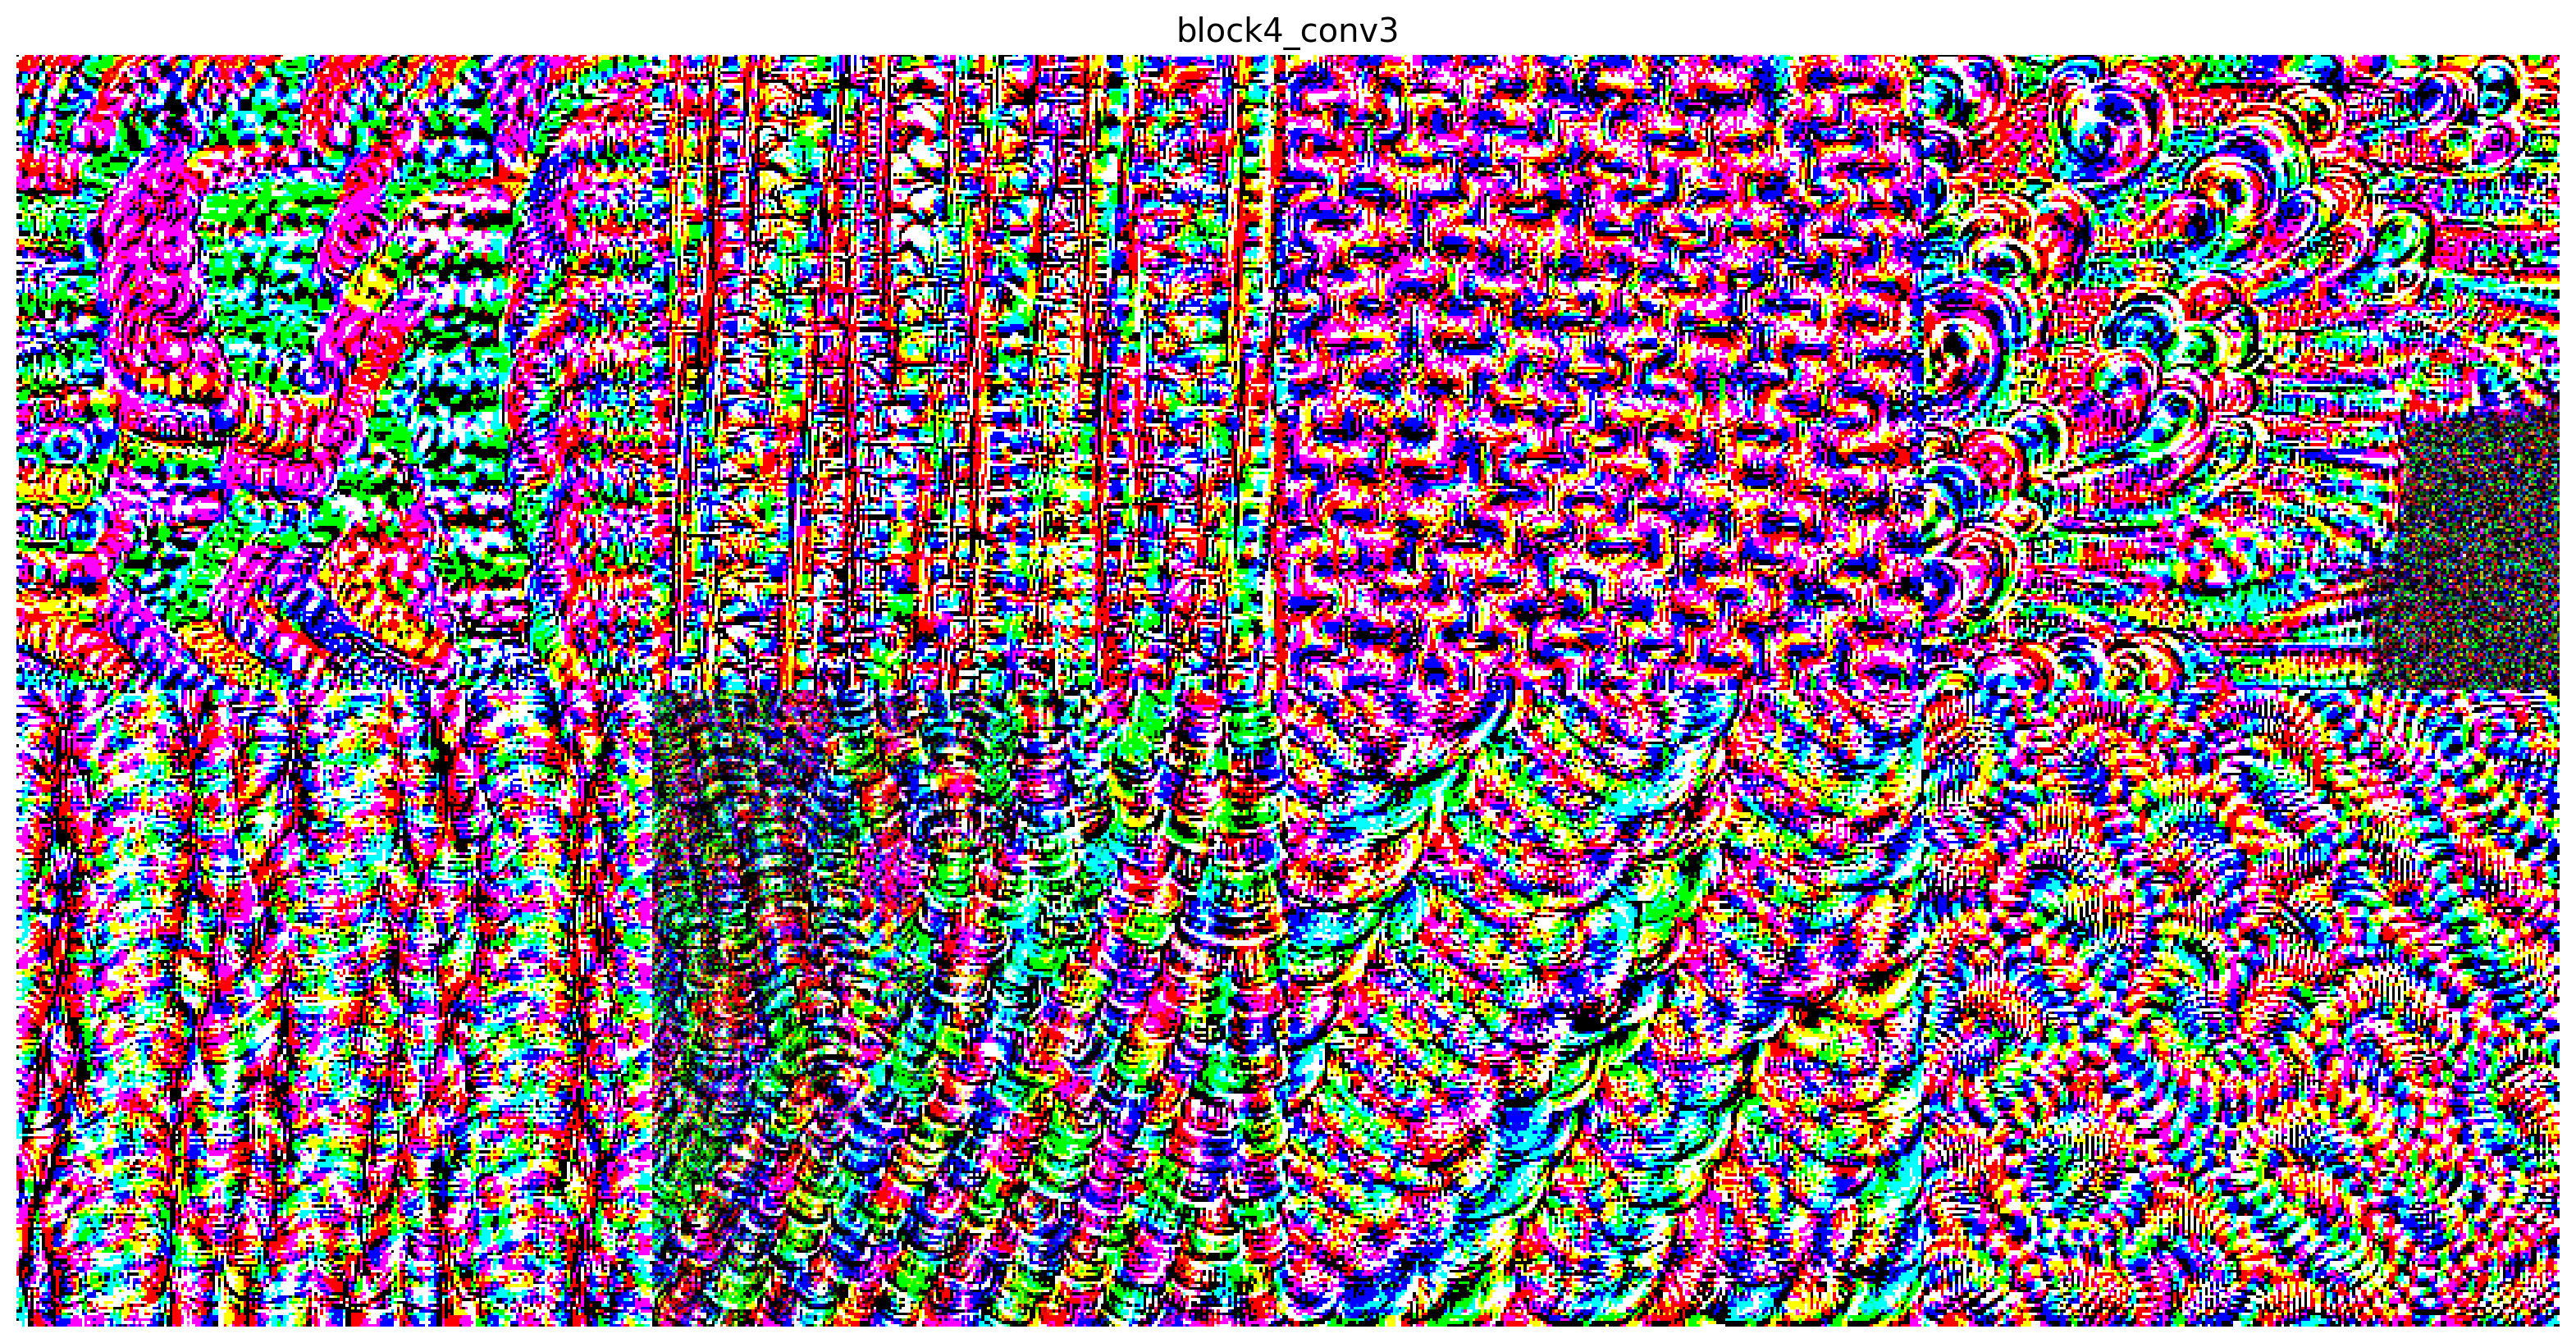

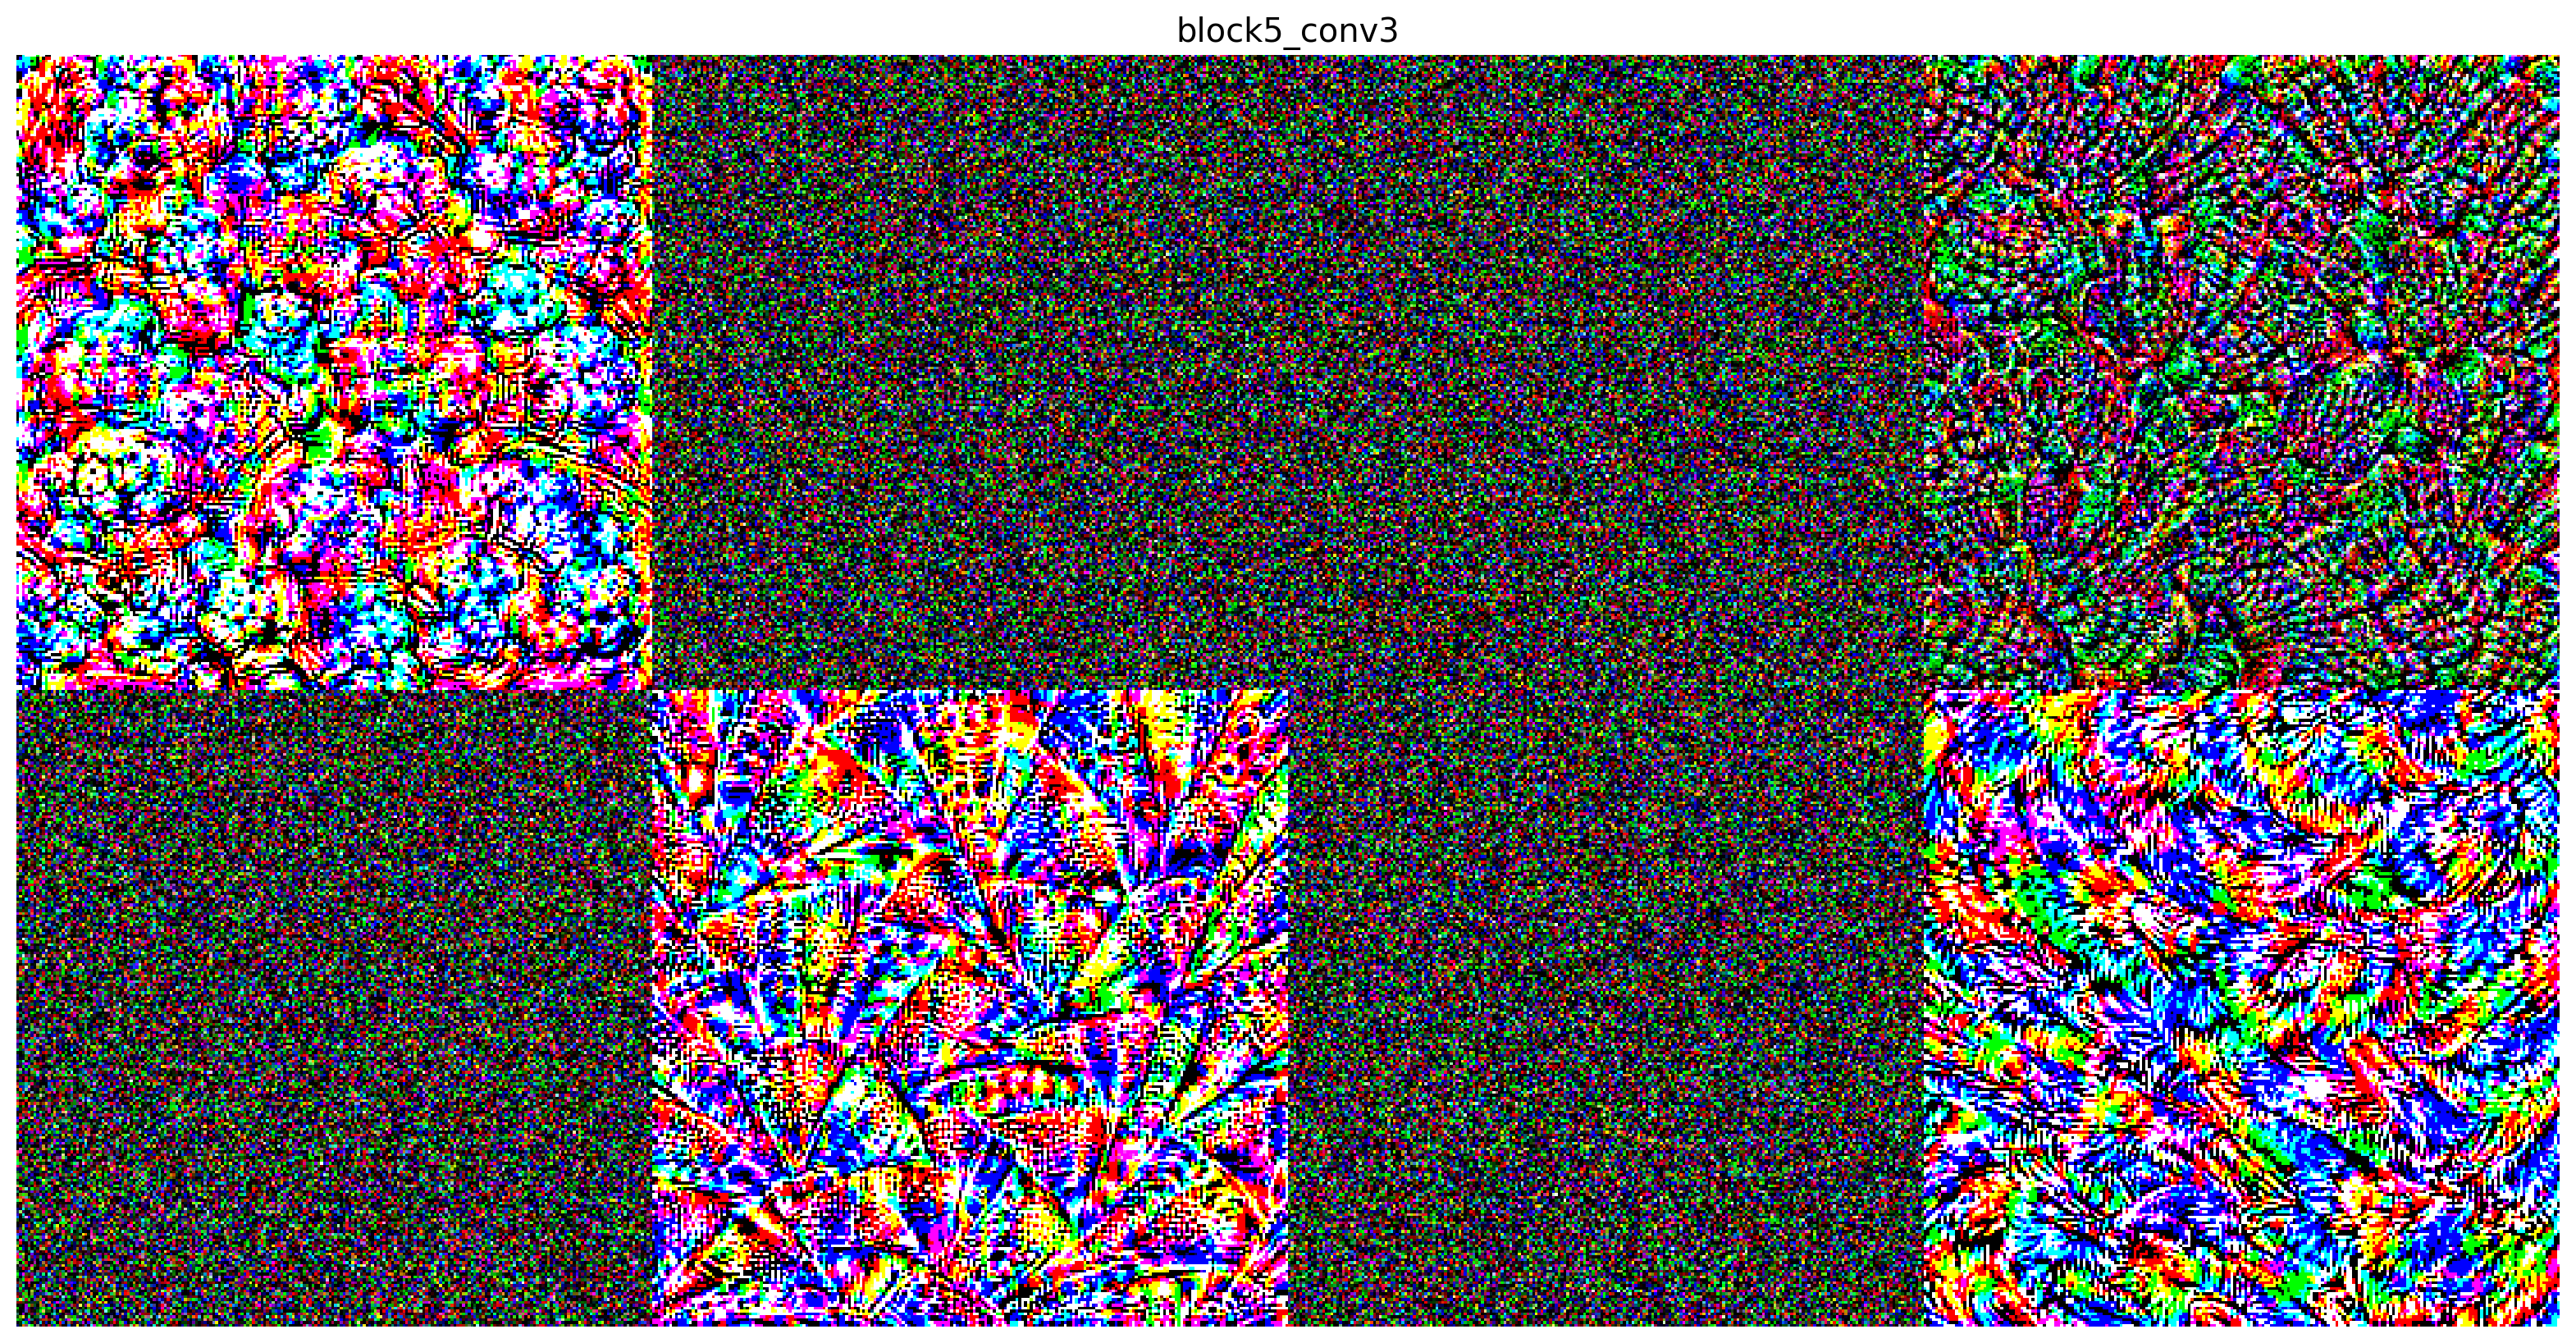

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Define the Jitter input modifier
def Jitter(jitter_strength):
    def jitter(image):
        return image + tf.random.uniform(tf.shape(image), -jitter_strength, jitter_strength)
    return jitter

# Define the visualize_activation function
def visualize_activation(model, layer_idx, filter_indices=None, seed_input=None, max_iter=300, tv_weight=1e-4, input_modifiers=None):
    # Ensure filter_indices is a list
    if not isinstance(filter_indices, list):
        filter_indices = [filter_indices]

    # Get the layer by index
    layer = model.layers[layer_idx]

    # Create a new model that outputs the activations of the specified layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer.output)

    # Initialize the input image
    if seed_input is None:
        # Generate random image as initial seed input
        seed_input = np.random.uniform(-0.5, 0.5, (224, 224, 3)).astype(np.float32)
    else:
        # Ensure seed_input is a float32 array with the correct shape
        seed_input = np.array(seed_input).astype(np.float32)
        # Remove the batch dimension if present
        if seed_input.ndim == 4 and seed_input.shape[0] == 1:
            seed_input = seed_input[0]

    input_img = tf.Variable(seed_input)

    # Define the loss function
    def loss_fn():
        activations = activation_model(input_img[tf.newaxis, ...])  # Add batch dimension
        if filter_indices:
            filter_activations = [tf.reduce_mean(activations[0, :, :, idx]) for idx in filter_indices]
            loss = -tf.reduce_sum(filter_activations)
        else:
            loss = -tf.reduce_mean(activations)

        # Total variation loss
        if tv_weight > 0:
            tv_loss = tf.image.total_variation(input_img)
            loss += tv_weight * tv_loss

        return loss

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Optimization loop
    for _ in range(max_iter):
        with tf.GradientTape() as tape:
            loss = loss_fn()
        grads = tape.gradient(loss, input_img)
        optimizer.apply_gradients([(grads, input_img)])

        # Apply input modifiers if any
        if input_modifiers:
            for modifier in input_modifiers:
                input_img.assign(modifier(input_img))

    # Post-process the result
    img_array = input_img.numpy()
    img_array = np.clip(img_array, 0, 1)  # Clip values to be between 0 and 1
    img_array = array_to_img(img_array)

    return img_array

# Define the draw_text function
def draw_text(img, text, position=(10, 10), font_size=20):
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(position, text, font=font, fill=(255, 255, 255))
    return img

# Define the find_layer_idx function
def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    raise ValueError(f"Layer with name {layer_name} not found in the model.")

# Define the stitch_images function
def stitch_images(images, cols=4):
    if not images:
        return None

    img_width, img_height = images[0].size
    rows = (len(images) + cols - 1) // cols
    stitched_image = Image.new('RGB', (cols * img_width, rows * img_height))

    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        stitched_image.paste(img, (col * img_width, row * img_height))

    return stitched_image

# Load a pre-trained model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

# Example indices for filters
max_filters = 40
selected_indices = []
vis_images = [[], [], [], [], []]
i = 0
selected_filters = [[0, 3, 11, 25, 26, 33, 42, 62],
    [8, 21, 23, 38, 39, 45, 50, 79],
    [40, 48, 52, 54, 81, 107, 224, 226],
    [58, 79, 86, 216, 307, 426, 497, 509],
    [2, 7, 41, 84, 103, 306, 461, 487]]

for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    if selected_filters:
        filters = selected_filters[i]
    else:
        filters = sorted(np.random.permutation(get_num_filters(model.layers[layer_idx]))[:max_filters])
    selected_indices.append(filters)

    # Generate input image for each filter.
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx, tv_weight=0.,
                                   input_modifiers=[Jitter(0.05)], max_iter=300)
        vis_images[i].append(img)

    # Generate stitched image palette with 4 cols so we get 2 rows.
    stitched = stitch_images(vis_images[i], cols=4)
    plt.figure(figsize=(20, 30))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()
    i += 1


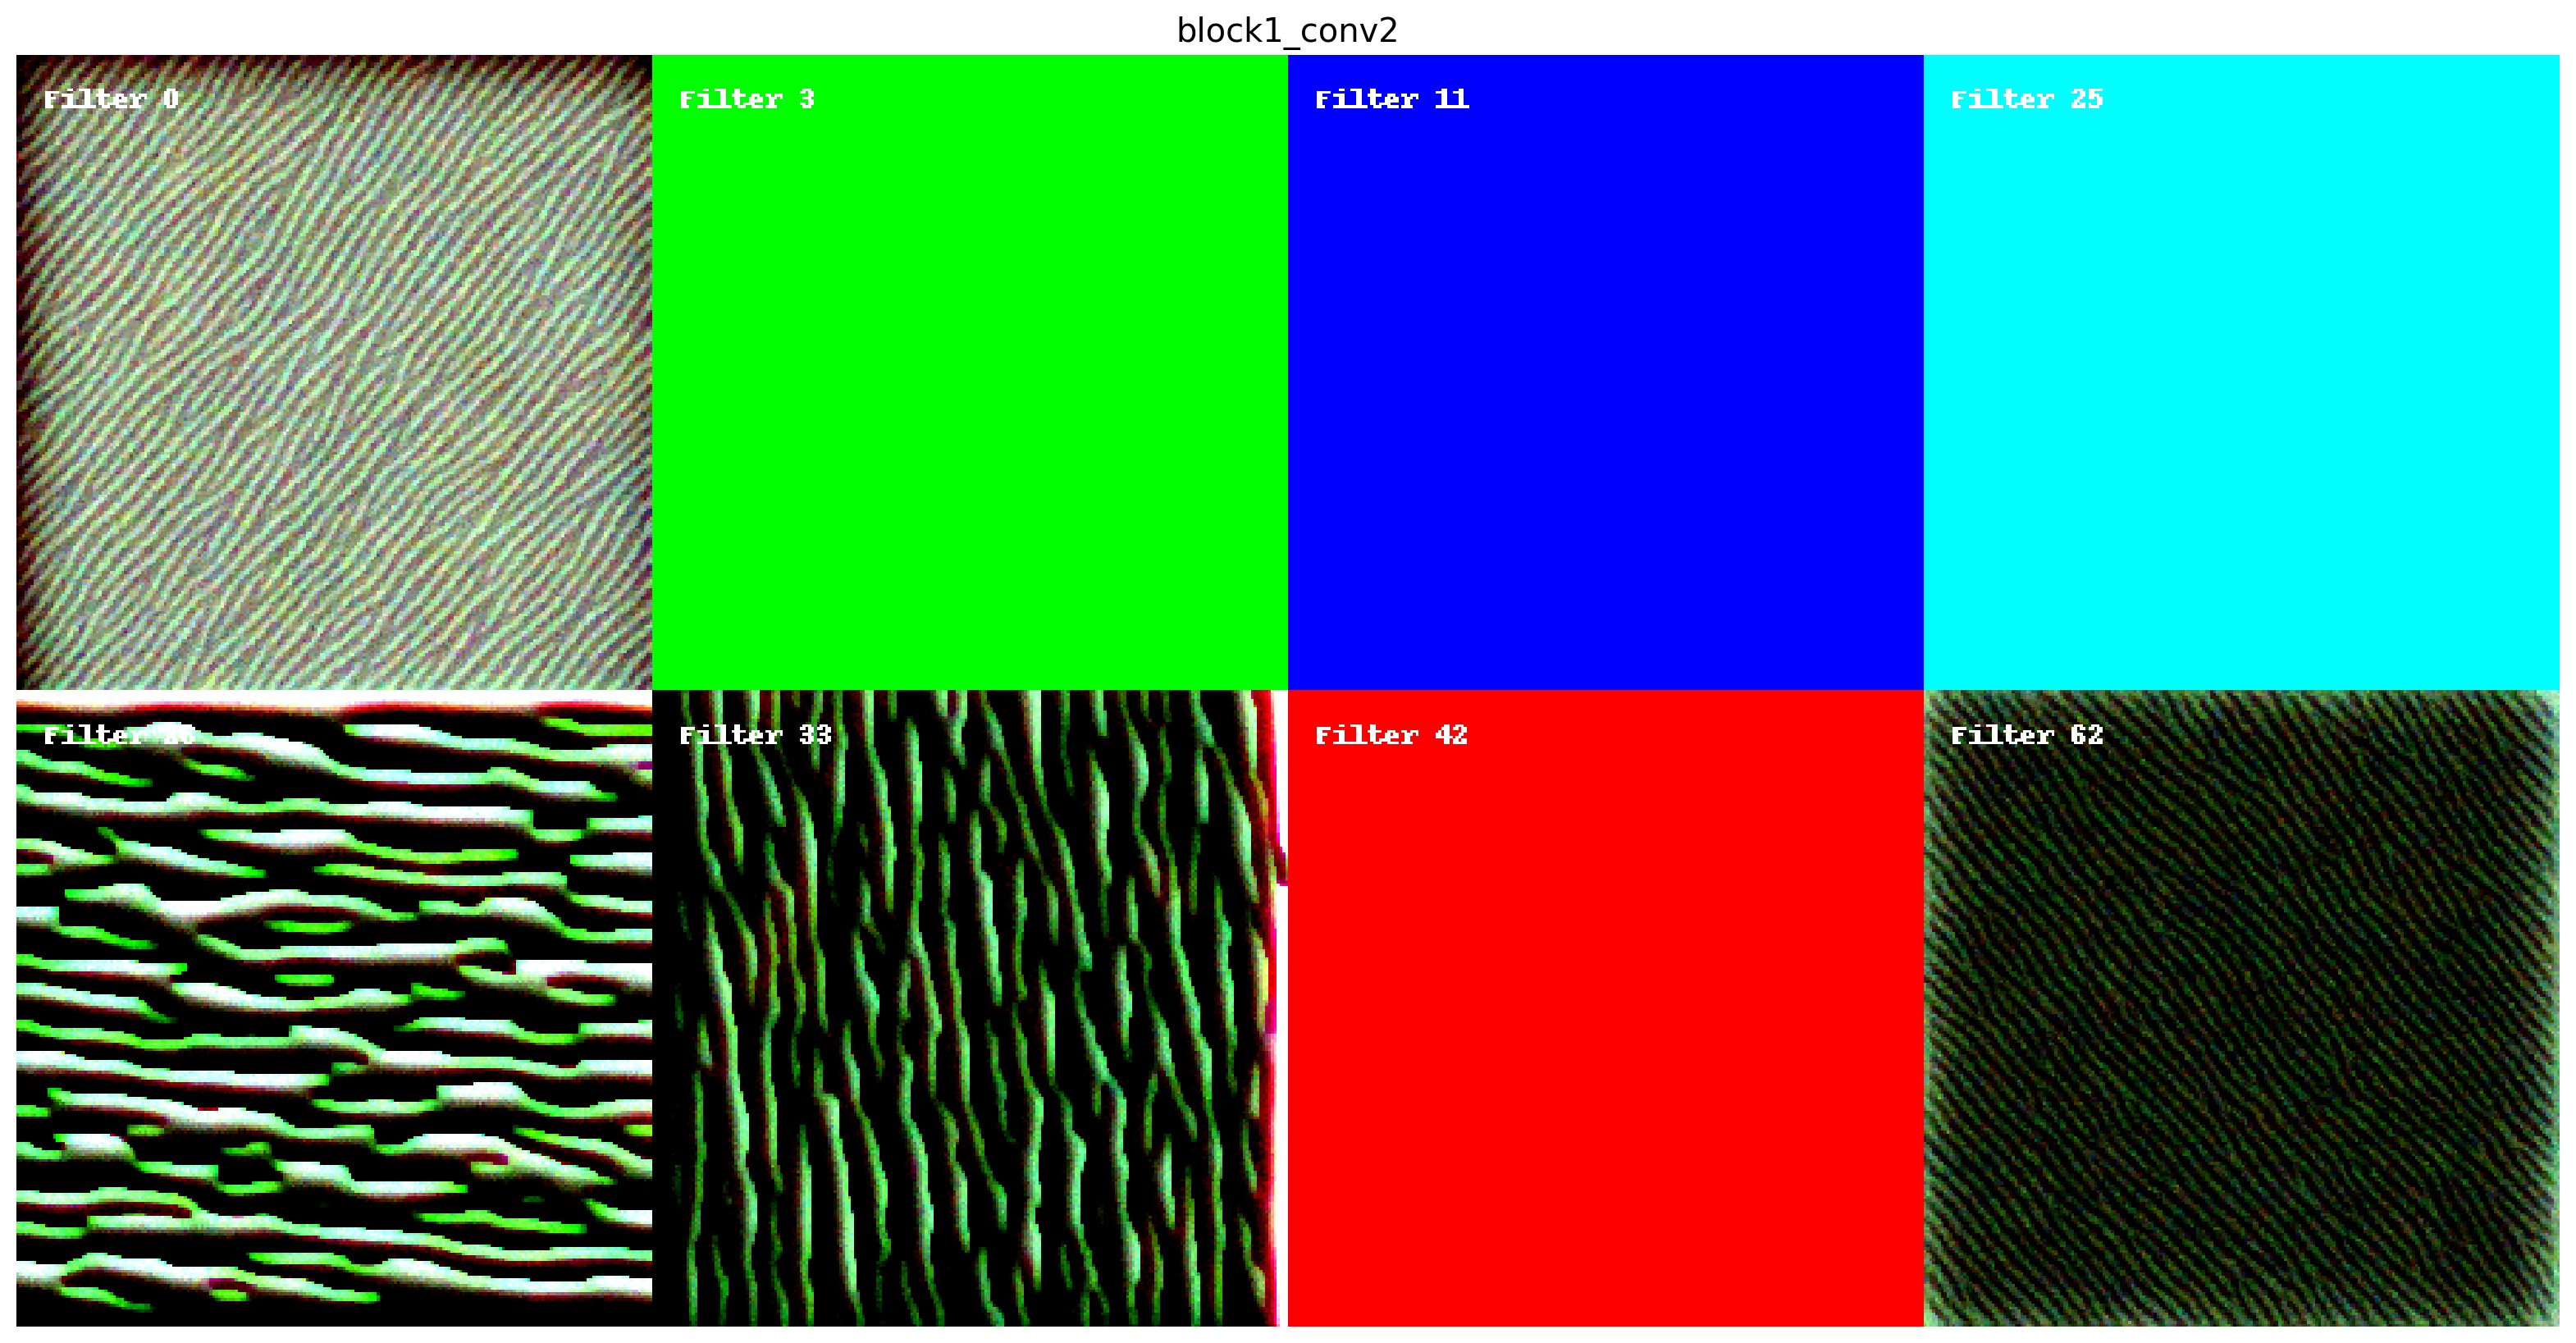

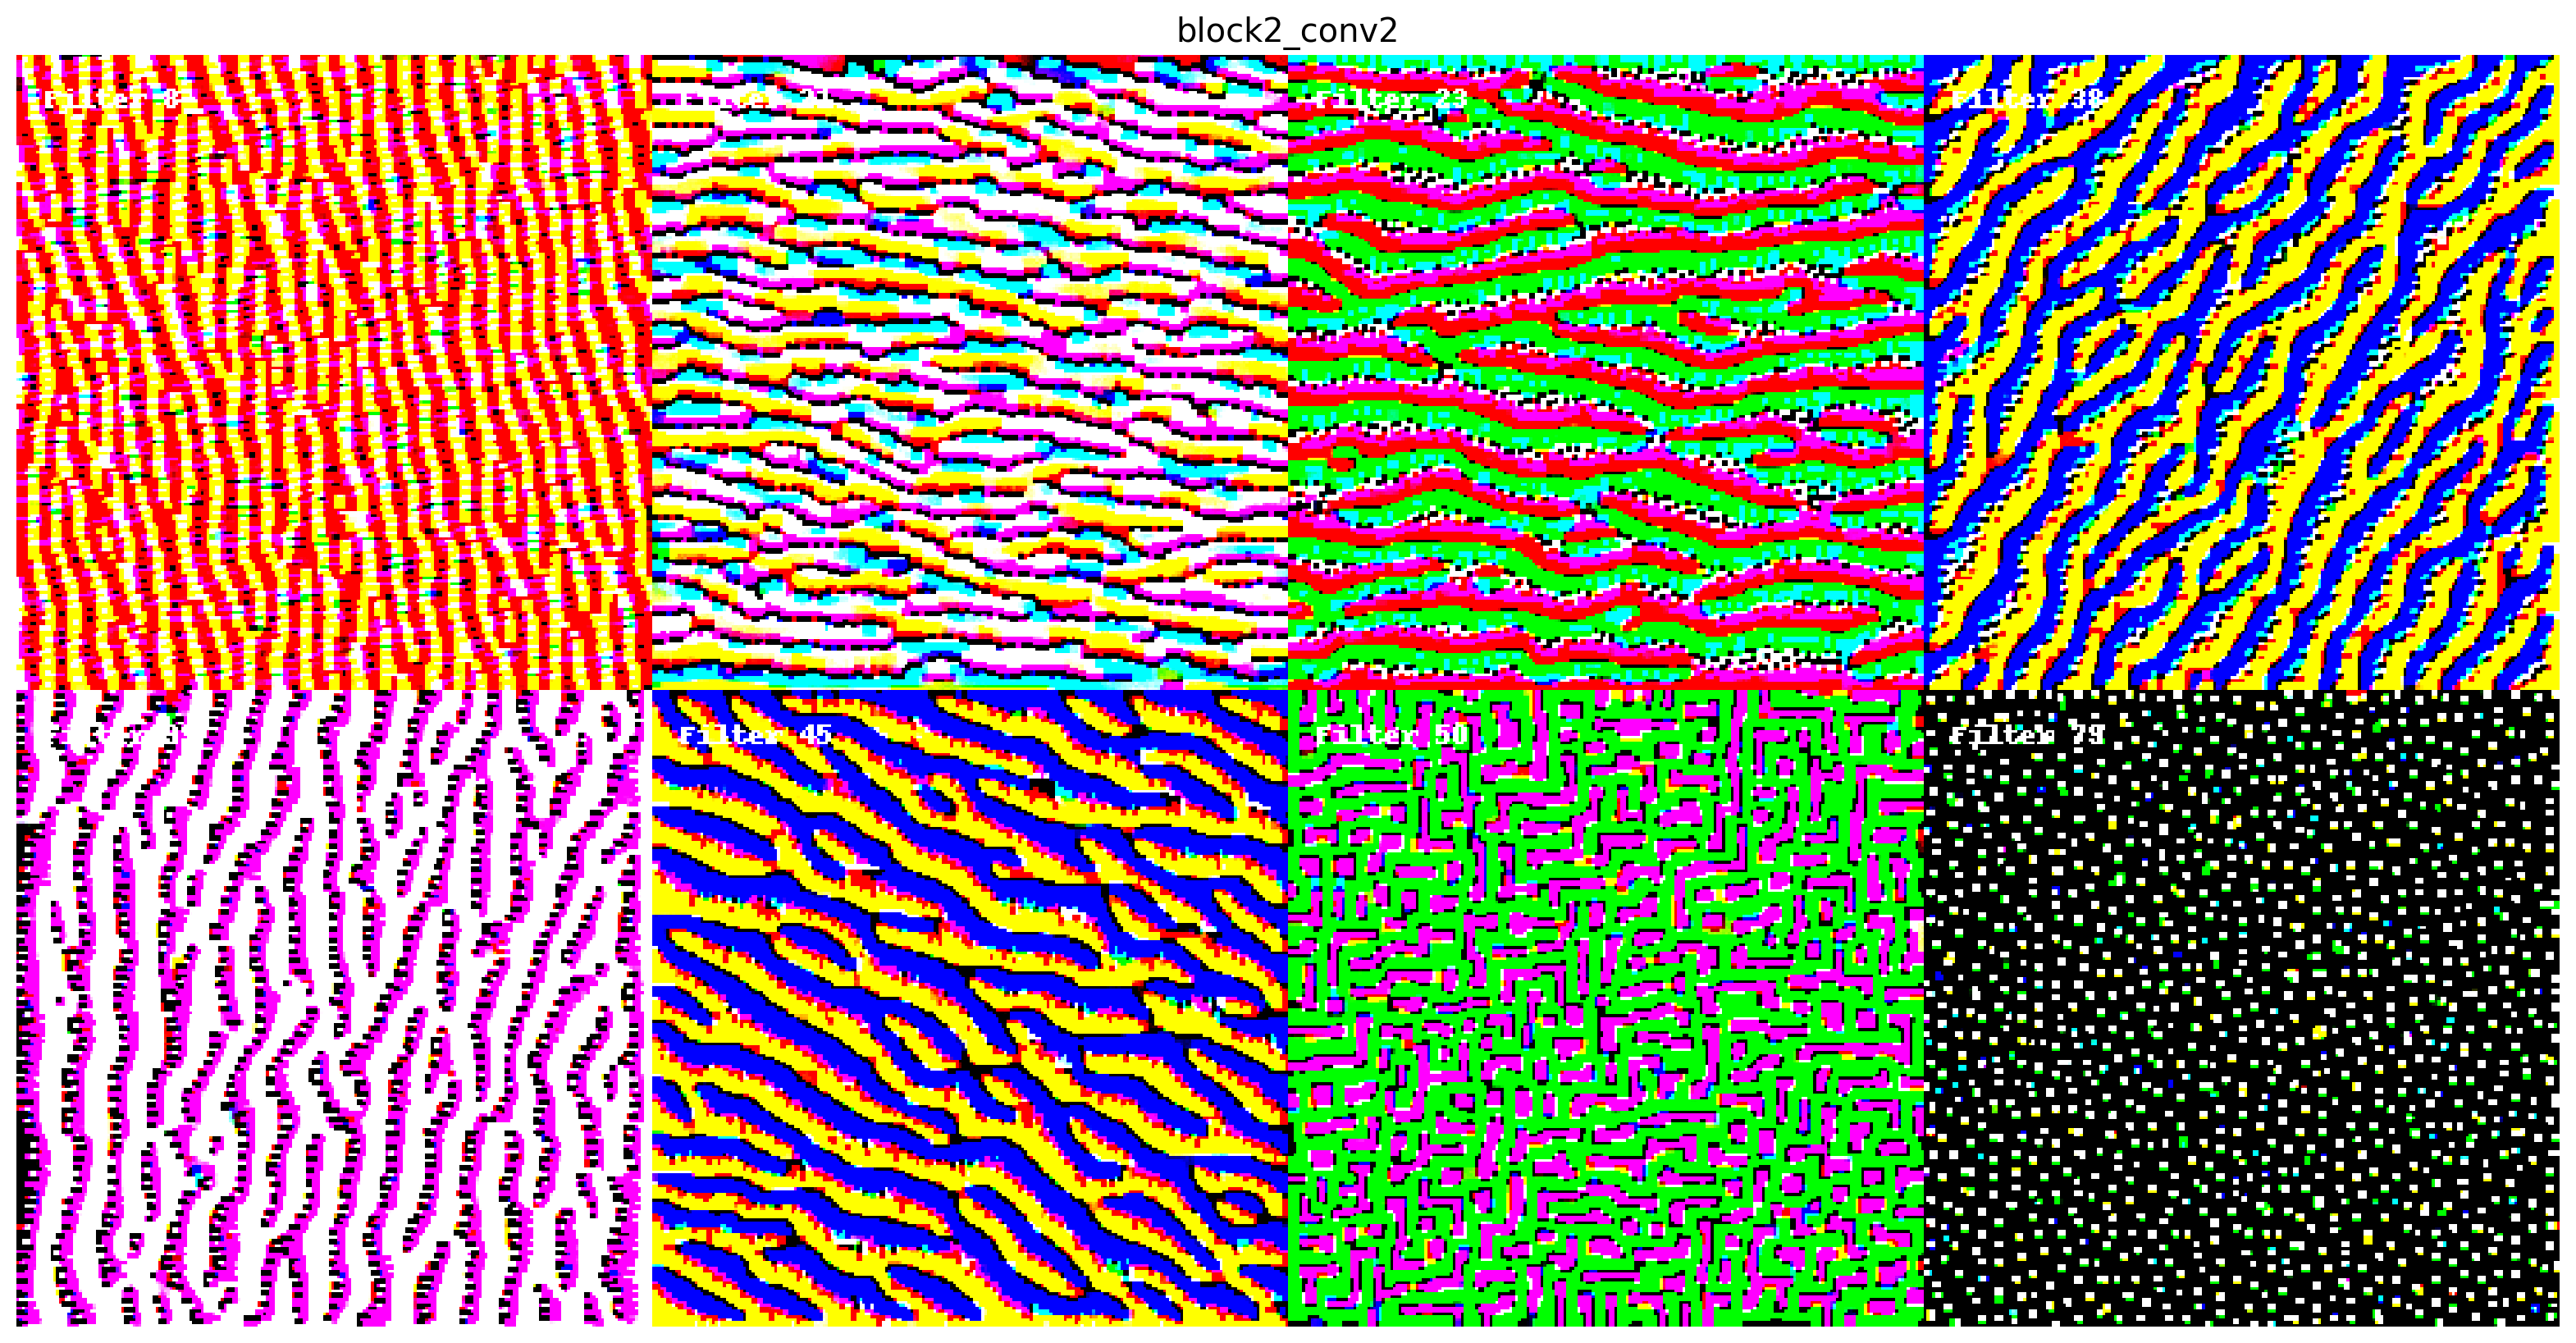

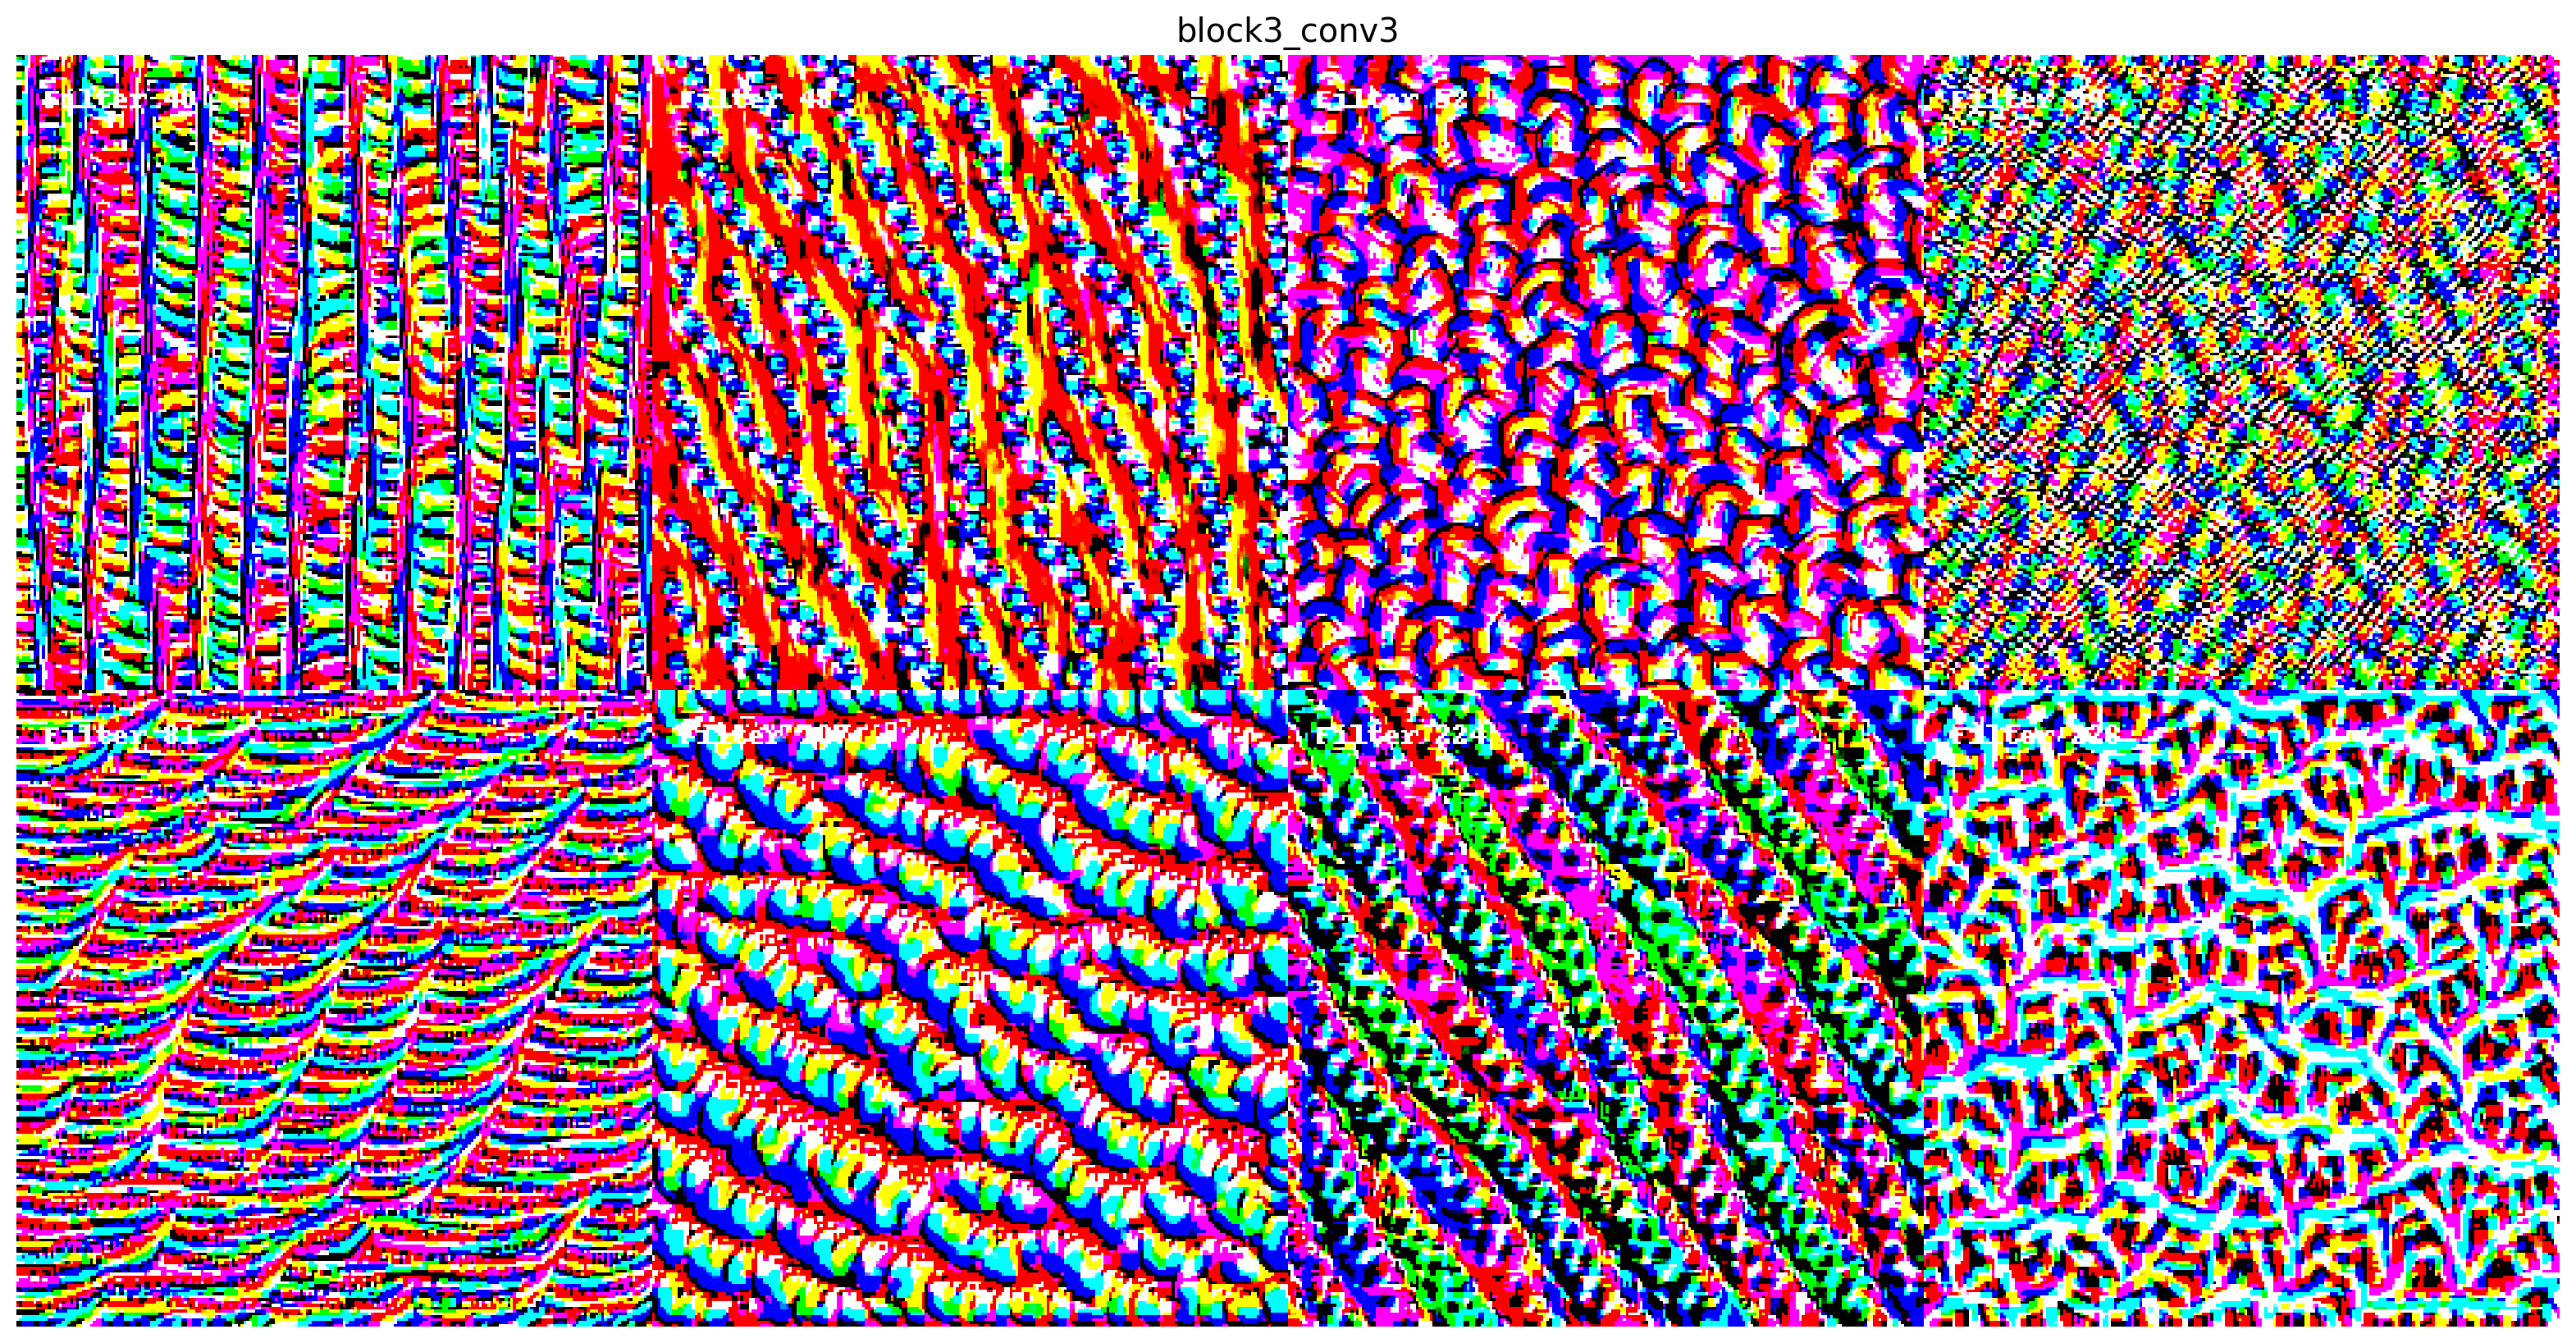

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Define the Jitter input modifier
def Jitter(jitter_strength):
    def jitter(image):
        return image + tf.random.uniform(tf.shape(image), -jitter_strength, jitter_strength)
    return jitter

# Define the visualize_activation function
def visualize_activation(model, layer_idx, filter_indices=None, seed_input=None, max_iter=300, tv_weight=1e-4, input_modifiers=None):
    # Ensure filter_indices is a list
    if not isinstance(filter_indices, list):
        filter_indices = [filter_indices]

    # Get the layer by index
    layer = model.layers[layer_idx]

    # Create a new model that outputs the activations of the specified layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer.output)

    # Initialize the input image
    if seed_input is None:
        # Generate random image as initial seed input
        seed_input = np.random.uniform(-0.5, 0.5, (224, 224, 3)).astype(np.float32)
    else:
        # Ensure seed_input is a float32 array with the correct shape
        seed_input = np.array(seed_input).astype(np.float32)
        # Remove the batch dimension if present
        if seed_input.ndim == 4 and seed_input.shape[0] == 1:
            seed_input = seed_input[0]

    input_img = tf.Variable(seed_input)

    # Define the loss function
    def loss_fn():
        activations = activation_model(input_img[tf.newaxis, ...])  # Add batch dimension
        if filter_indices:
            filter_activations = [tf.reduce_mean(activations[0, :, :, idx]) for idx in filter_indices]
            loss = -tf.reduce_sum(filter_activations)
        else:
            loss = -tf.reduce_mean(activations)

        # Total variation loss
        if tv_weight > 0:
            tv_loss = tf.image.total_variation(input_img)
            loss += tv_weight * tv_loss

        return loss

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    # Optimization loop
    for _ in range(max_iter):
        with tf.GradientTape() as tape:
            loss = loss_fn()
        grads = tape.gradient(loss, input_img)
        optimizer.apply_gradients([(grads, input_img)])

        # Apply input modifiers if any
        if input_modifiers:
            for modifier in input_modifiers:
                input_img.assign(modifier(input_img))

    # Post-process the result
    img_array = input_img.numpy()
    img_array = np.clip(img_array, 0, 1)  # Clip values to be between 0 and 1
    img_array = array_to_img(img_array)

    return img_array

# Convert array to PIL image
def array_to_img(array):
    array = np.uint8(array * 255)
    return Image.fromarray(array)

# Define the draw_text function
def draw_text(img, text, position=(10, 10), font_size=20):
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(position, text, font=font, fill=(255, 255, 255))
    return img

# Define the stitch_images function
def stitch_images(images, cols=4):
    if not images:
        return None

    img_width, img_height = images[0].size
    rows = (len(images) + cols - 1) // cols
    stitched_image = Image.new('RGB', (cols * img_width, rows * img_height))

    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        stitched_image.paste(img, (col * img_width, row * img_height))

    return stitched_image

# Define the find_layer_idx function
def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    raise ValueError(f"Layer with name {layer_name} not found in the model.")

# Load a pre-trained model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

# Example indices for filters
max_filters = 40
selected_indices = [[0, 3, 11, 25, 26, 33, 42, 62],
    [8, 21, 23, 38, 39, 45, 50, 79],
    [40, 48, 52, 54, 81, 107, 224, 226],
    [58, 79, 86, 216, 307, 426, 497, 509],
    [2, 7, 41, 84, 103, 306, 461, 487]]

vis_images = [[], [], [], [], []]
new_vis_images = [[], [], [], [], []]

# Generate images for each layer and filter
for i, layer_name in enumerate(['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']):
    layer_idx = find_layer_idx(model, layer_name)

    # Generate a random initial image if vis_images[i] is empty
    if not vis_images[i]:
        vis_images[i] = [np.random.uniform(-0.5, 0.5, (224, 224, 3)).astype(np.float32) for _ in selected_indices[i]]

    # Generate input image for each filter
    for j, idx in enumerate(selected_indices[i]):
        img = visualize_activation(model, layer_idx, filter_indices=idx,
                                   seed_input=vis_images[i][j], input_modifiers=[Jitter(0.05)])
        img = draw_text(img, 'Filter {}'.format(idx))
        new_vis_images[i].append(img)

    stitched = stitch_images(new_vis_images[i], cols=4)
    plt.figure(figsize=(20, 30))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()
